In [1]:
# Add the Model Scripts folder to the path
import sys
sys.path.append("Scripts")
sys.path.append("Weights")


# Import the necessary libraries
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import the function to create the model
from Scripts.ArithmeticTransformer import create_arithmetic_transformer

# Create a model with default parameters
model = create_arithmetic_transformer()

# Or create a model with custom parameters
model = create_arithmetic_transformer(
    vocab_size=14,
    embed_size=128,
    num_heads=4,
    ff_dim=512,
    num_layers=3,
    max_length=64
)

In [10]:
import torch

def load_model(model_path, device=None):
    # Determine device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load checkpoint
    print(f"Loading model on {device}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract config
    config = checkpoint['model_config']
    print("Model configuration:", config)
    
    # Create model
    model = create_arithmetic_transformer(
        vocab_size=config['vocab_size'],
        embed_size=config['embed_size'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_layers=config['num_layers'],
        max_length=config['max_length'],
        dropout=config['dropout']
    )
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move model to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    # Get vocab if available
    vocab = checkpoint.get('vocab')
    inv_vocab = checkpoint.get('inv_vocab')
    
    print(f"Model loaded successfully! Best accuracy: {checkpoint['accuracy']:.4f}")
    
    return model, vocab, inv_vocab, device, config

# Usage:
model_path = './Weights/large_addition_model.pth'
model, vocab, inv_vocab, device, config = load_model(model_path)

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


In [38]:
# If you need to use the model for inference, you'll want these helper functions:
def preprocess_input(input_str, max_length, vocab):
    # Reverse the input string
    input_str = input_str[::-1]
    # Tokenize
    tokens = [vocab[c] for c in input_str if c in vocab]
    # Pad
    padded = tokens + [vocab['<PAD>']] * (max_length - len(tokens))
    return torch.tensor(padded).unsqueeze(0)  # Add batch dimension

def decode_output(output_tensor, inv_vocab):
    _, predicted = output_tensor.max(2)
    decoded = []
    for token in predicted[0]:
        token_val = token.item()
        if token_val == vocab['<EOS>']:
            break
        if token_val != vocab['<PAD>']:
            decoded.append(inv_vocab[token_val])
    return ''.join(decoded)[::-1]  # Reverse at the end

# Example usage:
def test_addition(num1, num2, model, vocab, inv_vocab, max_length):
    input_str = f"{num1}+{num2}="
    input_tensor = preprocess_input(input_str, max_length, vocab)
    with torch.no_grad():
        output = model(input_tensor)
        result = decode_output(output, inv_vocab)
    print(f"{num1} + {num2} = {result}")
    print(f"Correct result: {num1 + num2}")
    print(f"Model's prediction is {'correct' if int(result) == num1 + num2 else 'incorrect'}")

In [39]:
# Test a simple addition
test_addition(123, 456, model, vocab, inv_vocab, config['max_length'])

# or test multiple additions in a loop
test_cases = [
    (5, 7),
    (42, 58),
    (123, 456),
    (1234, 5678)
]

for num1, num2 in test_cases:
    test_addition(num1, num2, model, vocab, inv_vocab, config['max_length'])

123 + 456 = 579
Correct result: 579
Model's prediction is correct
5 + 7 = 12
Correct result: 12
Model's prediction is correct
42 + 58 = 100
Correct result: 100
Model's prediction is correct
123 + 456 = 579
Correct result: 579
Model's prediction is correct
1234 + 5678 = 6912
Correct result: 6912
Model's prediction is correct


In [40]:
  # Test a simple addition
test_addition(123, 456, model, vocab, inv_vocab, config['max_length'])

# or test multiple additions in a loop
test_cases = [
    (5, 7),
    (42, 58),
    (123, 456),
    (1234, 5678),
    (10304923, 123123123),
    (123123123, 10304923)

]

for num1, num2 in test_cases:
    test_addition(num1, num2, model, vocab, inv_vocab, config['max_length'])

123 + 456 = 579
Correct result: 579
Model's prediction is correct
5 + 7 = 12
Correct result: 12
Model's prediction is correct
42 + 58 = 100
Correct result: 100
Model's prediction is correct
123 + 456 = 579
Correct result: 579
Model's prediction is correct
1234 + 5678 = 6912
Correct result: 6912
Model's prediction is correct
10304923 + 123123123 = 133428046
Correct result: 133428046
Model's prediction is correct
123123123 + 10304923 = 133428046
Correct result: 133428046
Model's prediction is correct


In [41]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import random

class ArithmeticModelTester:
    def __init__(self, model, vocab, inv_vocab, max_seq_length):
        self.model = model
        self.vocab = vocab
        self.inv_vocab = inv_vocab
        self.max_seq_length = max_seq_length
        self.model.eval()
        self.results = defaultdict(dict)
        
    def preprocess_input(self, input_str):
        """Preprocess input string for model"""
        input_str = input_str[::-1]  # Reverse string
        tokens = [self.vocab[c] for c in input_str if c in self.vocab]
        padded = tokens + [self.vocab['<PAD>']] * (self.max_seq_length - len(tokens))
        return torch.tensor(padded).unsqueeze(0)
    
    def decode_output(self, output_tensor):
        """Decode model output"""
        _, predicted = output_tensor.max(2)
        decoded = []
        for token in predicted[0]:
            token_val = token.item()
            if token_val == self.vocab['<EOS>']:
                break
            if token_val != self.vocab['<PAD>']:
                decoded.append(self.inv_vocab[token_val])
        return ''.join(decoded)[::-1]

    def test_single_digits(self, num_trials=100):
        """Test single digit additions"""
        correct = 0
        for _ in range(num_trials):
            n1 = random.randint(0, 9)
            n2 = random.randint(0, 9)
            result = self.predict_addition(n1, n2)
            if result == n1 + n2:
                correct += 1
        self.results['single_digits'] = {'accuracy': correct/num_trials}
        return correct/num_trials

    def test_commutative_property(self, max_digit=999, num_trials=100):
        """Test if a + b == b + a"""
        correct = 0
        for _ in range(num_trials):
            n1 = random.randint(0, max_digit)
            n2 = random.randint(0, max_digit)
            result1 = self.predict_addition(n1, n2)
            result2 = self.predict_addition(n2, n1)
            if result1 == result2 == (n1 + n2):
                correct += 1
        self.results['commutative'] = {'accuracy': correct/num_trials}
        return correct/num_trials

    def test_zero_property(self, max_digit=999, num_trials=100):
        """Test additions with zero"""
        correct = 0
        for _ in range(num_trials):
            n = random.randint(0, max_digit)
            result1 = self.predict_addition(n, 0)
            result2 = self.predict_addition(0, n)
            if result1 == result2 == n:
                correct += 1
        self.results['zero_property'] = {'accuracy': correct/num_trials}
        return correct/num_trials

    def test_by_length(self, max_length=5):
        """Test additions with different number lengths"""
        results = {}
        for length in range(1, max_length + 1):
            correct = 0
            trials = 100
            for _ in range(trials):
                n1 = random.randint(10**(length-1), 10**length - 1)
                n2 = random.randint(10**(length-1), 10**length - 1)
                result = self.predict_addition(n1, n2)
                if result == n1 + n2:
                    correct += 1
            results[length] = correct/trials
        self.results['length_wise'] = results
        return results

    def test_carries(self):
        """Test additions requiring different numbers of carries"""
        test_cases = [
            (9, 1),      # Single carry
            (99, 1),     # Double carry
            (999, 1),    # Triple carry
            (19, 81),    # Multiple carries
            (999999, 1)  # Many carries
        ]
        results = {}
        for n1, n2 in test_cases:
            result = self.predict_addition(n1, n2)
            results[f"{n1}+{n2}"] = result == n1 + n2
        self.results['carries'] = results
        return results

    def predict_addition(self, n1, n2):
        """Make a prediction for n1 + n2"""
        input_str = f"{n1}+{n2}="
        input_tensor = self.preprocess_input(input_str)
        with torch.no_grad():
            output = self.model(input_tensor)
            result_str = self.decode_output(output)
            try:
                return int(result_str)
            except ValueError:
                return None

    def visualize_results(self):
        """Visualize test results"""
        plt.figure(figsize=(15, 10))
        
        # Plot accuracy by number length
        if 'length_wise' in self.results:
            plt.subplot(2, 2, 1)
            lengths = list(self.results['length_wise'].keys())
            accuracies = list(self.results['length_wise'].values())
            plt.plot(lengths, accuracies, marker='o')
            plt.title('Accuracy by Number Length')
            plt.xlabel('Number Length (digits)')
            plt.ylabel('Accuracy')

        # Plot bar chart of different properties
        properties = ['single_digits', 'commutative', 'zero_property']
        accuracies = [self.results[prop]['accuracy'] for prop in properties if prop in self.results]
        if accuracies:
            plt.subplot(2, 2, 2)
            plt.bar(properties, accuracies)
            plt.title('Accuracy by Property')
            plt.xticks(rotation=45)
            plt.ylabel('Accuracy')

        plt.tight_layout()
        plt.show()

# Example usage:
"""
# Load your model and necessary components
model = load_model('path_to_model.pth')
vocab = {...}  # Your vocabulary
inv_vocab = {...}  # Inverse vocabulary
max_seq_length = 42  # Your max sequence length

# Create tester instance
tester = ArithmeticModelTester(model, vocab, inv_vocab, max_seq_length)

# Run tests
tester.test_single_digits()
tester.test_commutative_property()
tester.test_zero_property()
tester.test_by_length()
tester.test_carries()

# Visualize results
tester.visualize_results()
"""

"\n# Load your model and necessary components\nmodel = load_model('path_to_model.pth')\nvocab = {...}  # Your vocabulary\ninv_vocab = {...}  # Inverse vocabulary\nmax_seq_length = 42  # Your max sequence length\n\n# Create tester instance\ntester = ArithmeticModelTester(model, vocab, inv_vocab, max_seq_length)\n\n# Run tests\ntester.test_single_digits()\ntester.test_commutative_property()\ntester.test_zero_property()\ntester.test_by_length()\ntester.test_carries()\n\n# Visualize results\ntester.visualize_results()\n"

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import pandas as pd
from datetime import datetime

class ModelEvaluator:
    def __init__(self, model, vocab, inv_vocab, max_seq_length, random_seed=42):
        """
        Initialize evaluator with model and set random seed for reproducibility
        """
        self.model = model
        self.vocab = vocab
        self.inv_vocab = inv_vocab
        self.max_seq_length = max_seq_length
        self.model.eval()
        
        # Set random seeds for reproducibility
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        random.seed(random_seed)
        
        # Store test configuration
        self.test_config = {
            'random_seed': random_seed,
            'timestamp': datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
            'max_seq_length': max_seq_length
        }
        
    def generate_test_case(self, min_digits=1, max_digits=20):
        """Generate a random test case with specified digit length range"""
        len1 = random.randint(min_digits, max_digits)
        len2 = random.randint(min_digits, max_digits)
        
        num1 = random.randint(10**(len1-1), 10**len1 - 1)
        num2 = random.randint(10**(len2-1), 10**len2 - 1)
        
        return num1, num2, len1, len2

    def preprocess_input(self, input_str):
        """Preprocess input string for model"""
        input_str = input_str[::-1]  # Reverse string
        tokens = [self.vocab[c] for c in input_str if c in self.vocab]
        padded = tokens + [self.vocab['<PAD>']] * (self.max_seq_length - len(tokens))
        return torch.tensor(padded).unsqueeze(0)
    
    def decode_output(self, output_tensor):
        """Decode model output"""
        _, predicted = output_tensor.max(2)
        decoded = []
        for token in predicted[0]:
            token_val = token.item()
            if token_val == self.vocab['<EOS>']:
                break
            if token_val != self.vocab['<PAD>']:
                decoded.append(self.inv_vocab[token_val])
        return ''.join(decoded)[::-1]

    def evaluate_model(self, num_samples=10000):
        """
        Evaluate model on random test cases and collect detailed metrics
        """
        results = []
        
        for _ in tqdm(range(num_samples), desc="Evaluating Model"):
            # Generate test case
            num1, num2, len1, len2 = self.generate_test_case()
            true_result = num1 + num2
            
            # Get model prediction
            input_str = f"{num1}+{num2}="
            input_tensor = self.preprocess_input(input_str)
            
            with torch.no_grad():
                output = self.model(input_tensor)
                pred_str = self.decode_output(output)
                
            try:
                pred_result = int(pred_str)
                is_correct = pred_result == true_result
            except ValueError:
                pred_result = None
                is_correct = False
            
            # Collect detailed information about this test case
            results.append({
                'num1': num1,
                'num2': num2,
                'len1': len1,
                'len2': len2,
                'max_len': max(len1, len2),
                'total_len': len1 + len2,
                'true_result': true_result,
                'predicted_result': pred_result,
                'is_correct': is_correct,
                'carries': self.count_carries(num1, num2)
            })
        
        return pd.DataFrame(results)

    def count_carries(self, num1, num2):
        """Count the number of carry operations in addition"""
        carry = 0
        carries = 0
        
        while num1 > 0 or num2 > 0 or carry:
            digit1 = num1 % 10
            digit2 = num2 % 10
            
            if digit1 + digit2 + carry >= 10:
                carries += 1
                carry = 1
            else:
                carry = 0
                
            num1 //= 10
            num2 //= 10
            
        return carries

    def analyze_results(self, df):
        """
        Analyze results and generate comprehensive metrics
        """
        metrics = {
            'test_config': self.test_config,
            'overall_accuracy': df['is_correct'].mean(),
            'total_samples': len(df),
            'metrics_by_length': {},
            'metrics_by_carries': {}
        }
        
        # Analyze by maximum length of operands
        for length in range(1, 21):
            length_df = df[df['max_len'] == length]
            if len(length_df) > 0:
                metrics['metrics_by_length'][length] = {
                    'accuracy': length_df['is_correct'].mean(),
                    'samples': len(length_df)
                }
        
        # Analyze by number of carries
        for carries in df['carries'].unique():
            carries_df = df[df['carries'] == carries]
            metrics['metrics_by_carries'][int(carries)] = {
                'accuracy': carries_df['is_correct'].mean(),
                'samples': len(carries_df)
            }
        
        return metrics

    def visualize_results(self, df, metrics):
        """
        Create visualizations of model performance
        """
        plt.figure(figsize=(20, 10))
        
        # Plot 1: Accuracy by maximum length
        plt.subplot(2, 2, 1)
        lengths = list(metrics['metrics_by_length'].keys())
        accuracies = [metrics['metrics_by_length'][l]['accuracy'] for l in lengths]
        plt.plot(lengths, accuracies, marker='o')
        plt.title('Accuracy by Maximum Length of Operands')
        plt.xlabel('Maximum Length (digits)')
        plt.ylabel('Accuracy')
        
        # Plot 2: Accuracy by number of carries
        plt.subplot(2, 2, 2)
        carries = list(metrics['metrics_by_carries'].keys())
        carry_accuracies = [metrics['metrics_by_carries'][c]['accuracy'] for c in carries]
        plt.plot(carries, carry_accuracies, marker='o', color='orange')
        plt.title('Accuracy by Number of Carries')
        plt.xlabel('Number of Carries')
        plt.ylabel('Accuracy')
        
        # Plot 3: Distribution of test cases
        plt.subplot(2, 2, 3)
        sns.histplot(data=df, x='max_len', bins=20)
        plt.title('Distribution of Test Cases by Maximum Length')
        plt.xlabel('Maximum Length (digits)')
        
        # Plot 4: Heatmap of length combinations
        plt.subplot(2, 2, 4)
        heatmap_data = pd.crosstab(df['len1'], df['len2'])
        sns.heatmap(heatmap_data, cmap='YlOrRd')
        plt.title('Distribution of Length Combinations')
        plt.xlabel('Length of Second Number')
        plt.ylabel('Length of First Number')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
        print(f"Total Samples: {metrics['total_samples']}")

In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import pandas as pd
from datetime import datetime

# Recreate the model architecture (you'll need to import your model class)
from Scripts.ArithmeticTransformer import *
    

# First, let's load the model correctly
def load_model_and_config(model_path):
    """Load the model and its configuration"""    
    # Load checkpoint
    print(f"Loading model on {device}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract config
    config = checkpoint['model_config']
    print("Model configuration:", config)
    
    # Create model
    model = create_arithmetic_transformer(
        vocab_size=config['vocab_size'],
        embed_size=config['embed_size'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_layers=config['num_layers'],
        max_length=config['max_length'],
        dropout=config['dropout']
    )
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move model to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    # Get vocab if available
    vocab = checkpoint.get('vocab')
    inv_vocab = checkpoint.get('inv_vocab')
    
    print(f"Model loaded successfully! Best accuracy: {checkpoint['accuracy']:.4f}")
    
    return model, vocab, inv_vocab, config['max_length']
    
# [Previous ModelEvaluator class code remains the same]

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 64, 'num_heads': 2, 'ff_dim': 256, 'num_layers': 2, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.7937


Evaluating Model: 100%|██████████| 10000/10000 [00:23<00:00, 430.51it/s]


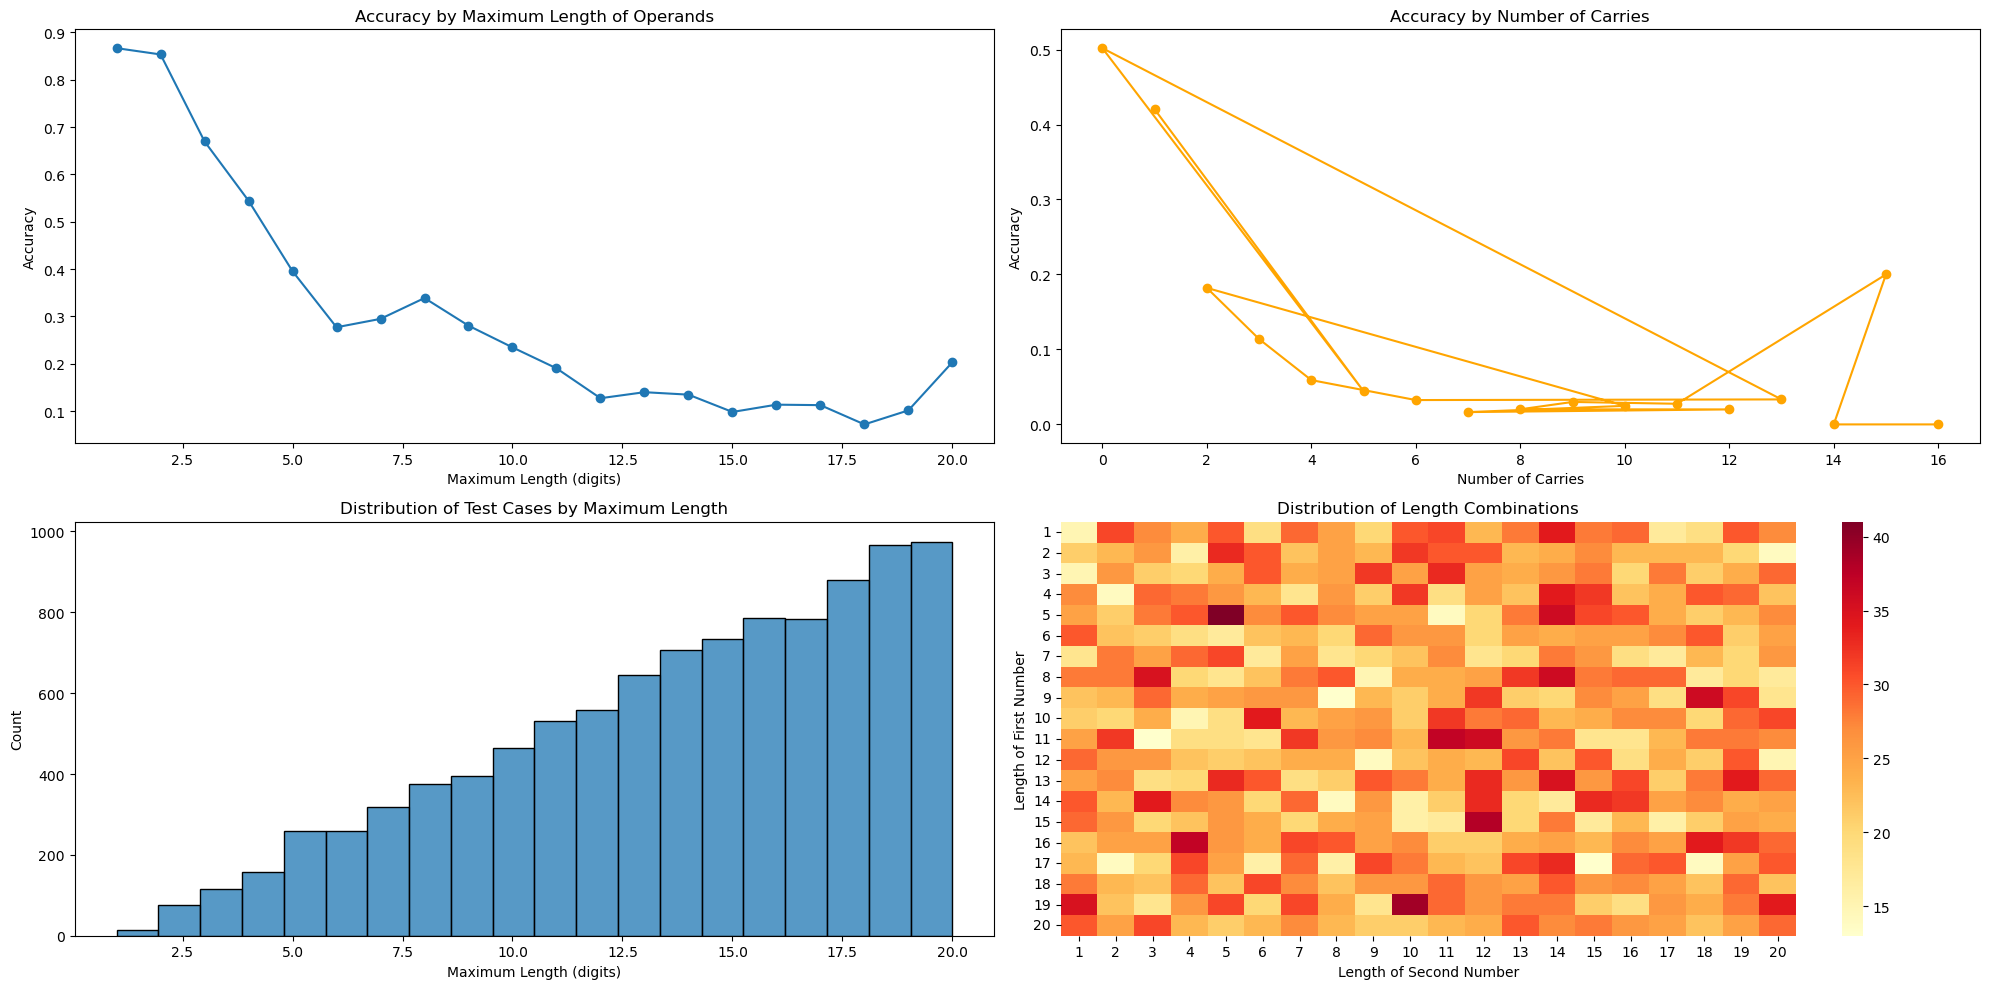


Summary Statistics:
Overall Accuracy: 0.1820
Total Samples: 10000

Detailed Statistics:
Number of correct predictions: 1820
Average number of carries: 3.65

Performance by length ranges:
1-5 digits: 0.5507
6-10 digits: 0.2826
11-15 digits: 0.1351
16-20 digits: 0.1221


In [15]:
# SMALL MODEL EVALUATION
# Load model and components
model_path = './Weights/small_addition_model.pth'  # Update with your model path
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed
evaluator = ModelEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(num_samples=10000)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'model_evaluation_{timestamp}.csv')

# Print some interesting statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

# Print performance by length ranges
print("\nPerformance by length ranges:")
length_ranges = [(1,5), (6,10), (11,15), (16,20)]
for start, end in length_ranges:
    mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
    acc = results_df[mask]['is_correct'].mean()
    print(f"{start}-{end} digits: {acc:.4f}")

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 256, 'num_heads': 4, 'ff_dim': 1024, 'num_layers': 4, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.9987


Evaluating Model: 100%|██████████| 10000/10000 [01:44<00:00, 96.03it/s]


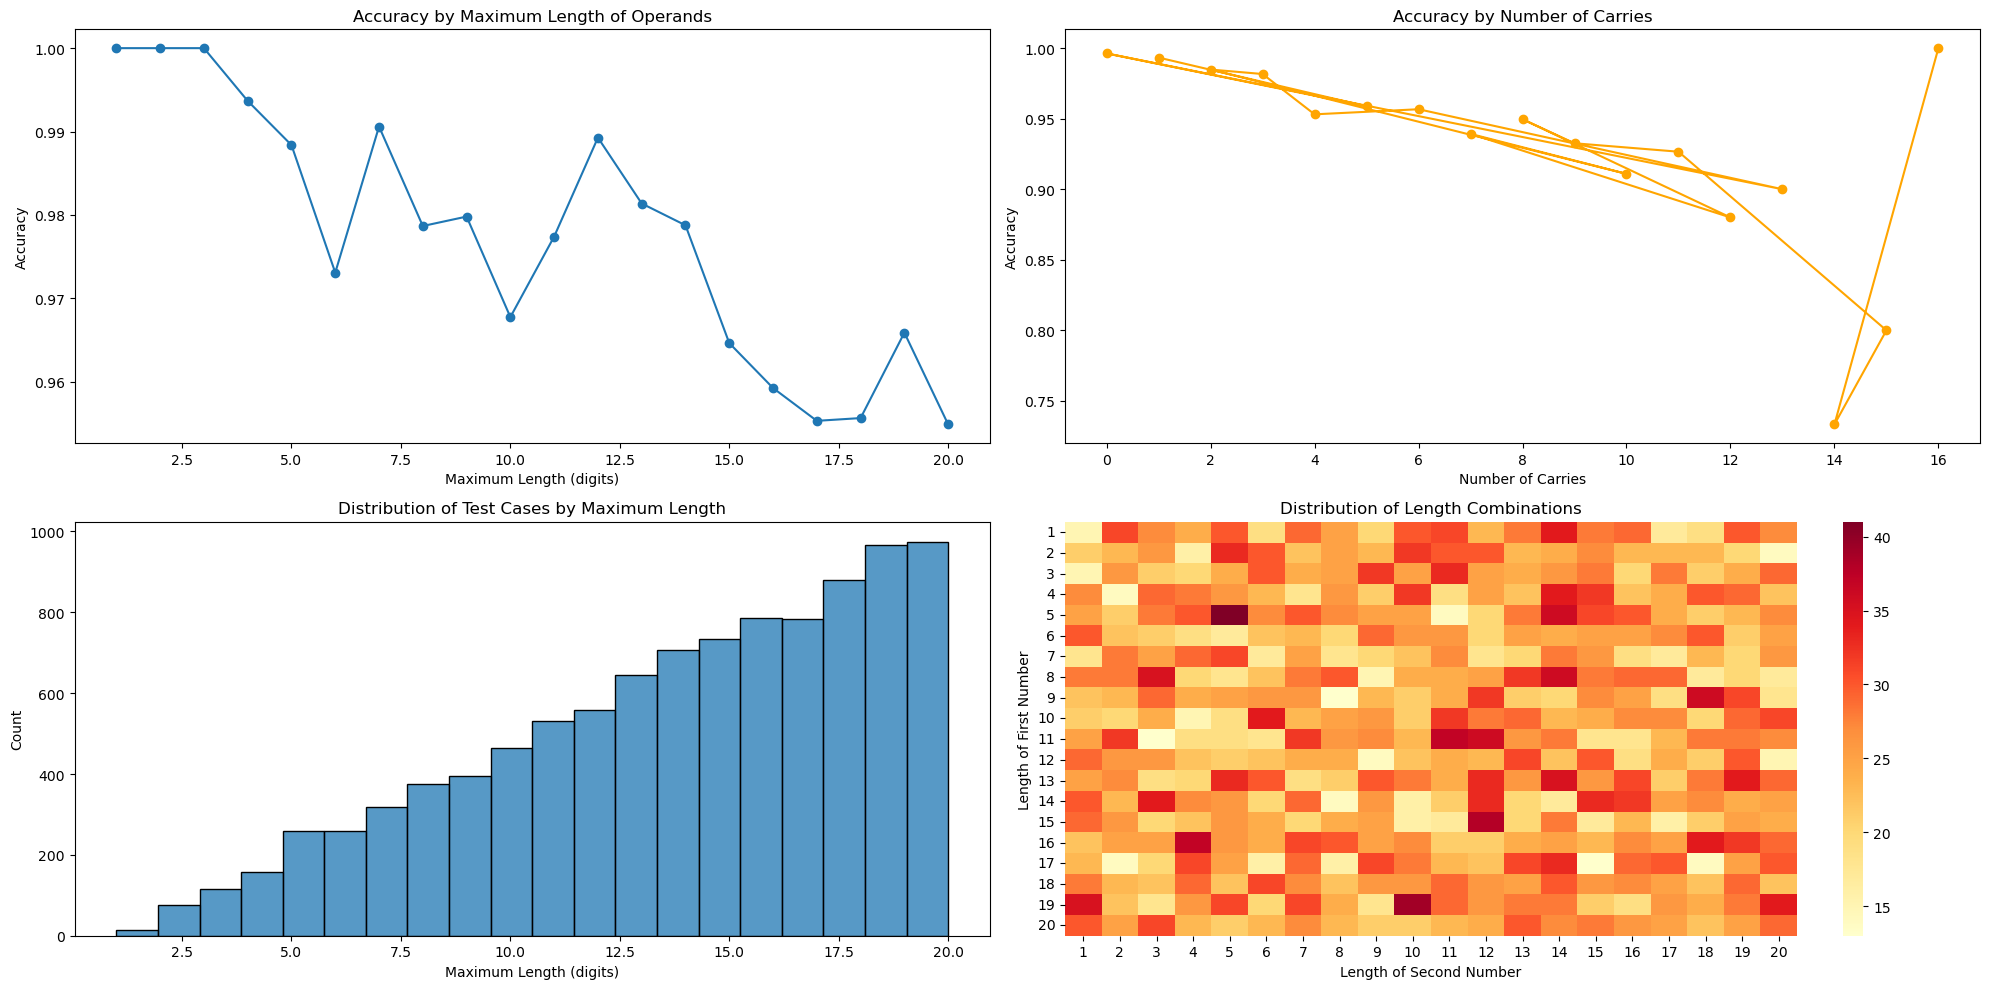


Summary Statistics:
Overall Accuracy: 0.9701
Total Samples: 10000

Detailed Statistics:
Number of correct predictions: 9701
Average number of carries: 3.65

Performance by length ranges:
1-5 digits: 0.9936
6-10 digits: 0.9774
11-15 digits: 0.9776
16-20 digits: 0.9583


In [51]:
# MEDUIM MODEL EVALUATION
# Load model and components
model_path = './Weights/medium_addition_model.pth'  # Update with your model path
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed
evaluator = ModelEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(num_samples=10000)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'model_evaluation_{timestamp}.csv')

# Print some interesting statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

# Print performance by length ranges
print("\nPerformance by length ranges:")
length_ranges = [(1,5), (6,10), (11,15), (16,20)]
for start, end in length_ranges:
    mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
    acc = results_df[mask]['is_correct'].mean()
    print(f"{start}-{end} digits: {acc:.4f}")

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


Evaluating Model: 100%|██████████| 10000/10000 [13:21<00:00, 12.47it/s]


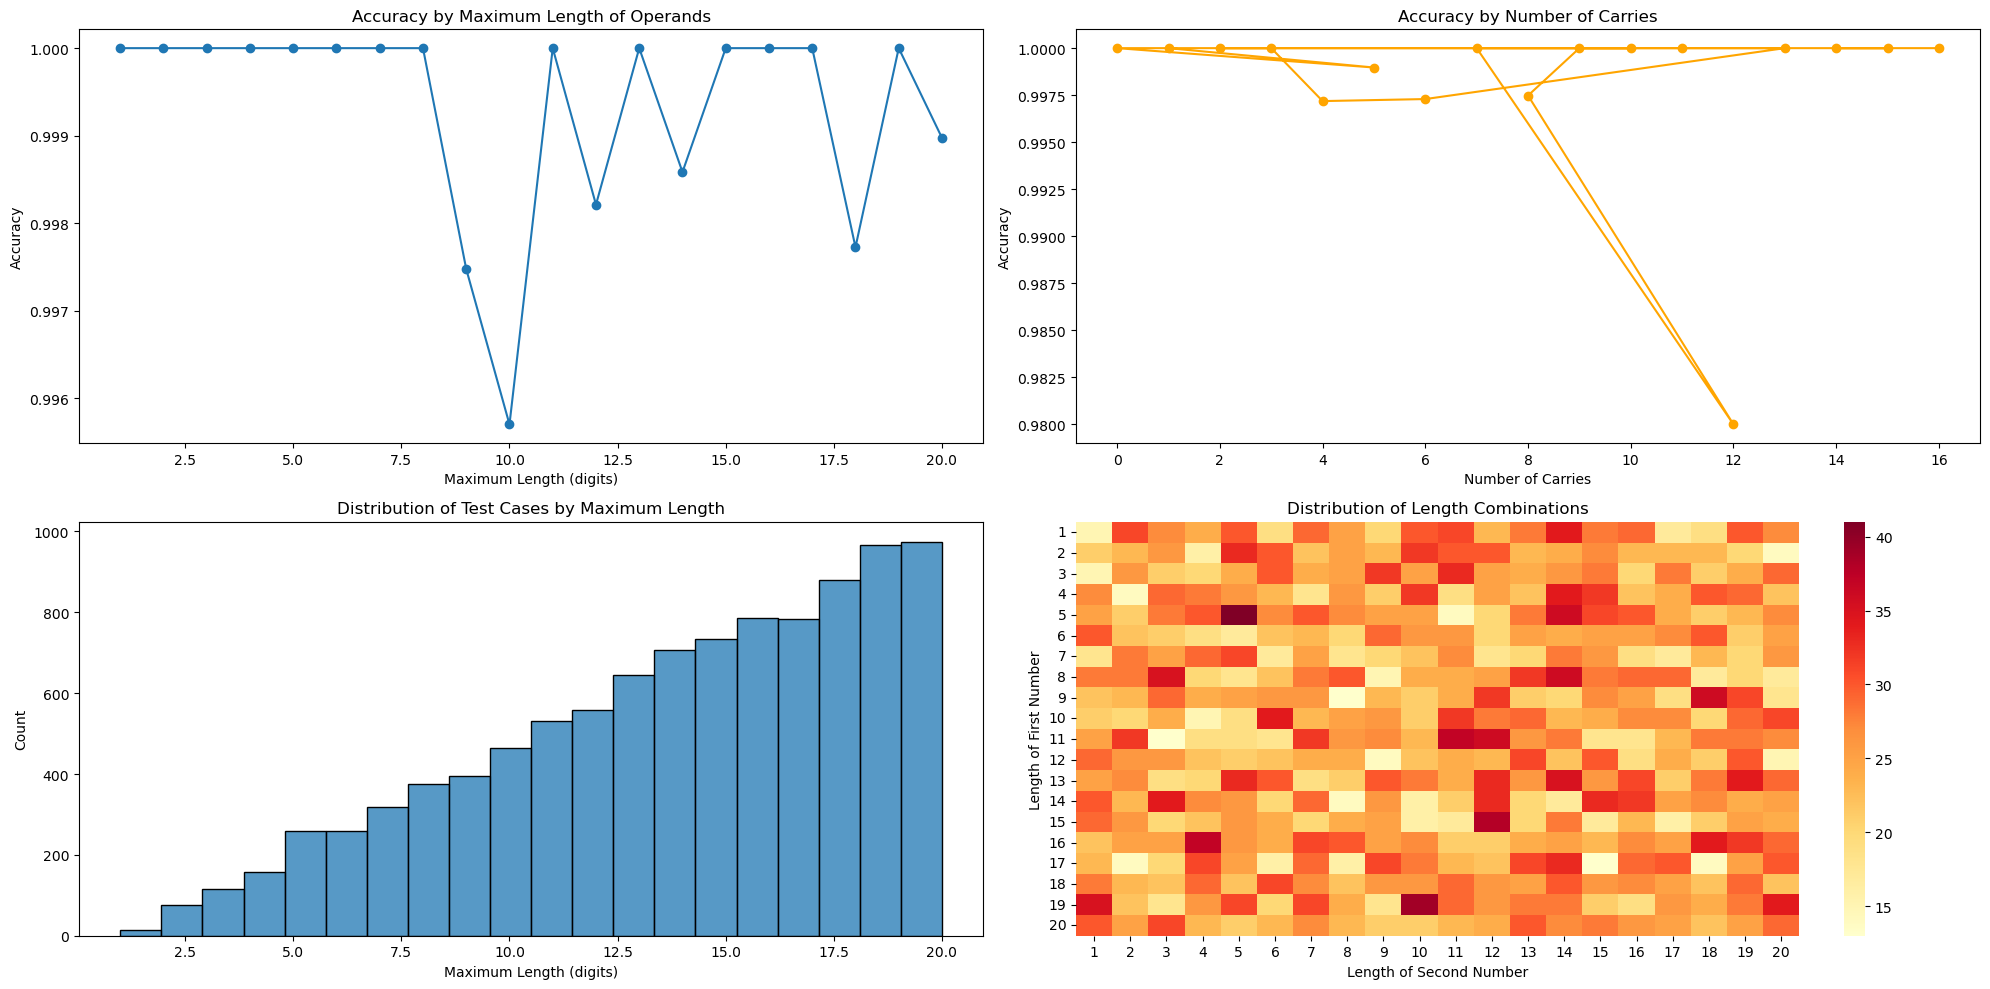


Summary Statistics:
Overall Accuracy: 0.9992
Total Samples: 10000

Detailed Statistics:
Number of correct predictions: 9992
Average number of carries: 3.65

Performance by length ranges:
1-5 digits: 1.0000
6-10 digits: 0.9983
11-15 digits: 0.9994
16-20 digits: 0.9993


In [53]:
# LARGE MODEL EVALUATION
# Load model and components
model_path = './Weights/large_addition_model.pth'  # Update with your model path
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed
evaluator = ModelEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(num_samples=10000)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'model_evaluation_{timestamp}.csv')

# Print some interesting statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

# Print performance by length ranges
print("\nPerformance by length ranges:")
length_ranges = [(1,5), (6,10), (11,15), (16,20)]
for start, end in length_ranges:
    mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
    acc = results_df[mask]['is_correct'].mean()
    print(f"{start}-{end} digits: {acc:.4f}")

In [7]:
# Helper functions for extended range testing
def generate_extended_test_case(min_digits=21, max_digits=25):
    """Generate a test case with specific digit length"""
    len1 = random.randint(min_digits, max_digits)
    len2 = random.randint(min_digits, max_digits)
    num1 = random.randint(10**(len1-1), (10**len1) - 1)
    num2 = random.randint(10**(len2-1), (10**len2) - 1)
    return num1, num2, len1, len2

class ExtendedRangeEvaluator(ModelEvaluator):
    def evaluate_model(self, samples_per_length=200):
        """
        Evaluate model with uniform distribution across 21-25 digits
        """
        results = []
        for target_length in range(21, 26):
            for _ in tqdm(range(samples_per_length), 
                         desc=f"Evaluating {target_length} digits"):
                # Generate numbers
                num1, num2, len1, len2 = generate_extended_test_case(
                    target_length, target_length)
                true_result = num1 + num2
                
                # Get model prediction
                input_str = f"{num1}+{num2}="
                input_tensor = self.preprocess_input(input_str)
                
                with torch.no_grad():
                    output = self.model(input_tensor)
                    pred_str = self.decode_output(output)
                
                try:
                    pred_result = int(pred_str)
                    is_correct = pred_result == true_result
                except ValueError:
                    pred_result = None
                    is_correct = False
                
                results.append({
                    'num1': num1,
                    'num2': num2,
                    'len1': len1,
                    'len2': len2,
                    'max_len': max(len1, len2),
                    'true_result': true_result,
                    'predicted_result': pred_result,
                    'is_correct': is_correct,
                    'carries': self.count_carries(num1, num2)
                })
        
        return pd.DataFrame(results)

# SMALL MODEL EXTENDED RANGE EVALUATION
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 64, 'num_heads': 2, 'ff_dim': 256, 'num_layers': 2, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.7937


Evaluating 25 digits: 100%|██████████| 200/200 [00:01<00:00, 169.77it/s]


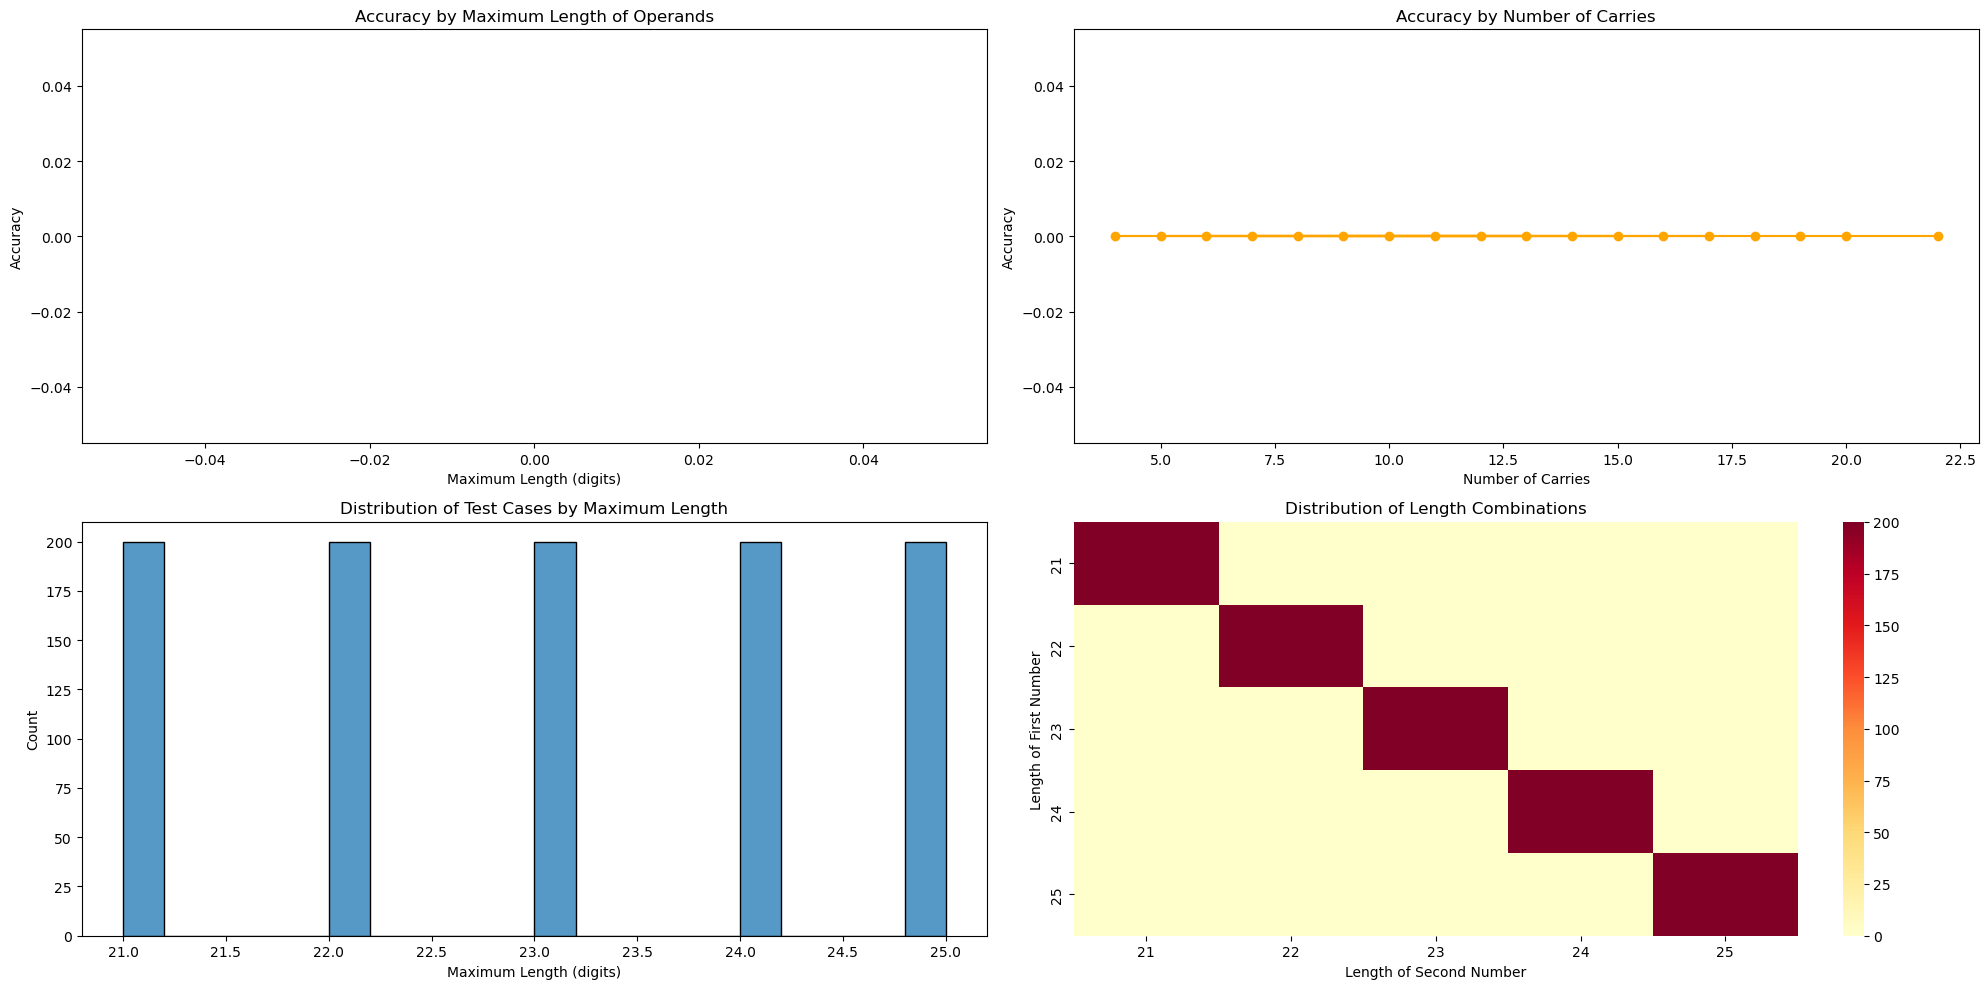


Summary Statistics:
Overall Accuracy: 0.0000
Total Samples: 1000

Detailed Statistics:
Number of correct predictions: 0
Average number of carries: 11.56

Performance by length:
21 digits: 0.0000 (200 samples)
22 digits: 0.0000 (200 samples)
23 digits: 0.0000 (200 samples)
24 digits: 0.0000 (200 samples)
25 digits: 0.0000 (200 samples)


In [11]:
# First cell: SMALL MODEL EXTENDED RANGE EVALUATION
print("# SMALL MODEL EXTENDED RANGE EVALUATION")
# Load model and components
model_path = './Weights/small_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator
evaluator = ExtendedRangeEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=200)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'extended_small_model_evaluation_{timestamp}.csv')

# Print statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

print("\nPerformance by length:")
for length in range(21, 26):
    mask = (results_df['max_len'] == length)
    acc = results_df[mask]['is_correct'].mean()
    samples = sum(mask)
    print(f"{length} digits: {acc:.4f} ({samples} samples)")




# MEDIUM MODEL EXTENDED RANGE EVALUATION
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 256, 'num_heads': 4, 'ff_dim': 1024, 'num_layers': 4, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.9987


Evaluating 25 digits: 100%|██████████| 200/200 [00:03<00:00, 59.23it/s]


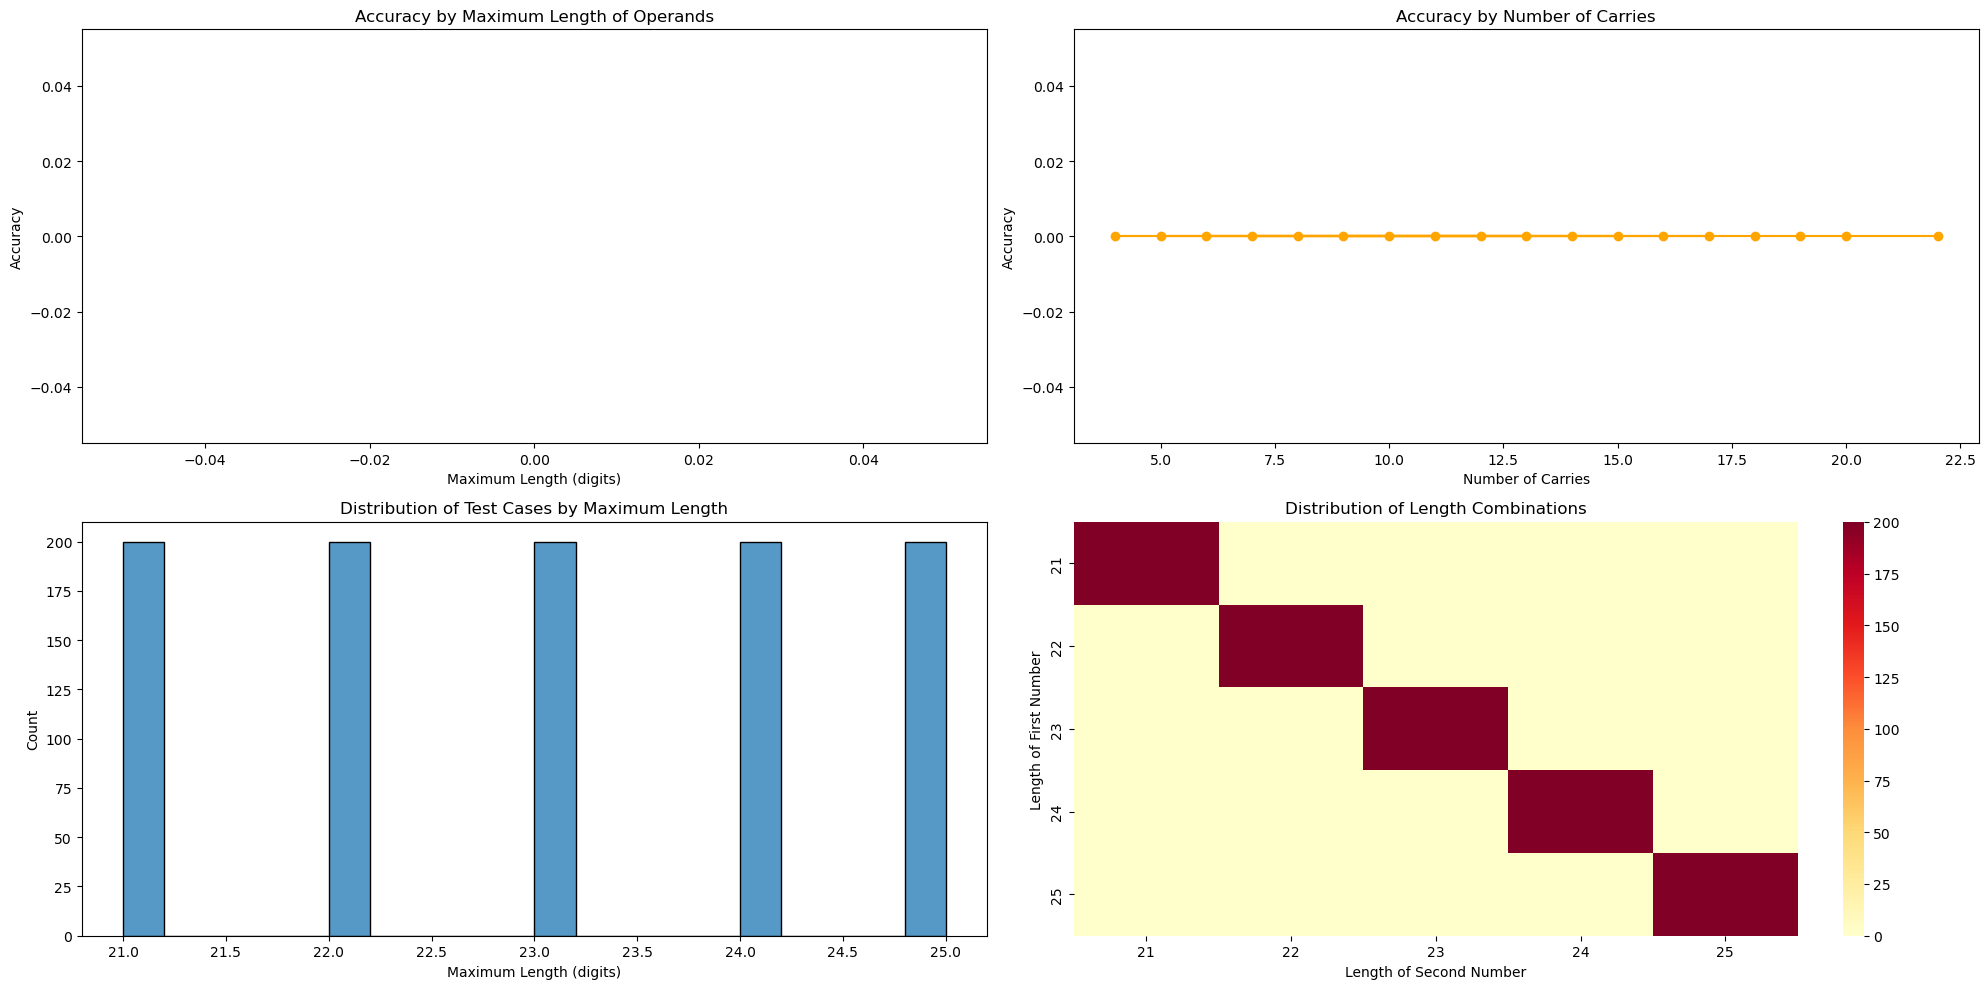


Summary Statistics:
Overall Accuracy: 0.0000
Total Samples: 1000

Detailed Statistics:
Number of correct predictions: 0
Average number of carries: 11.56

Performance by length:
21 digits: 0.0000 (200 samples)
22 digits: 0.0000 (200 samples)
23 digits: 0.0000 (200 samples)
24 digits: 0.0000 (200 samples)
25 digits: 0.0000 (200 samples)


In [12]:
# Second cell: MEDIUM MODEL EXTENDED RANGE EVALUATION
print("\n# MEDIUM MODEL EXTENDED RANGE EVALUATION")
# Load model and components
model_path = './Weights/medium_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator
evaluator = ExtendedRangeEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=200)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'extended_medium_model_evaluation_{timestamp}.csv')

# Print statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

print("\nPerformance by length:")
for length in range(21, 26):
    mask = (results_df['max_len'] == length)
    acc = results_df[mask]['is_correct'].mean()
    samples = sum(mask)
    print(f"{length} digits: {acc:.4f} ({samples} samples)")



# LARGE MODEL EXTENDED RANGE EVALUATION
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


Evaluating 25 digits: 100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


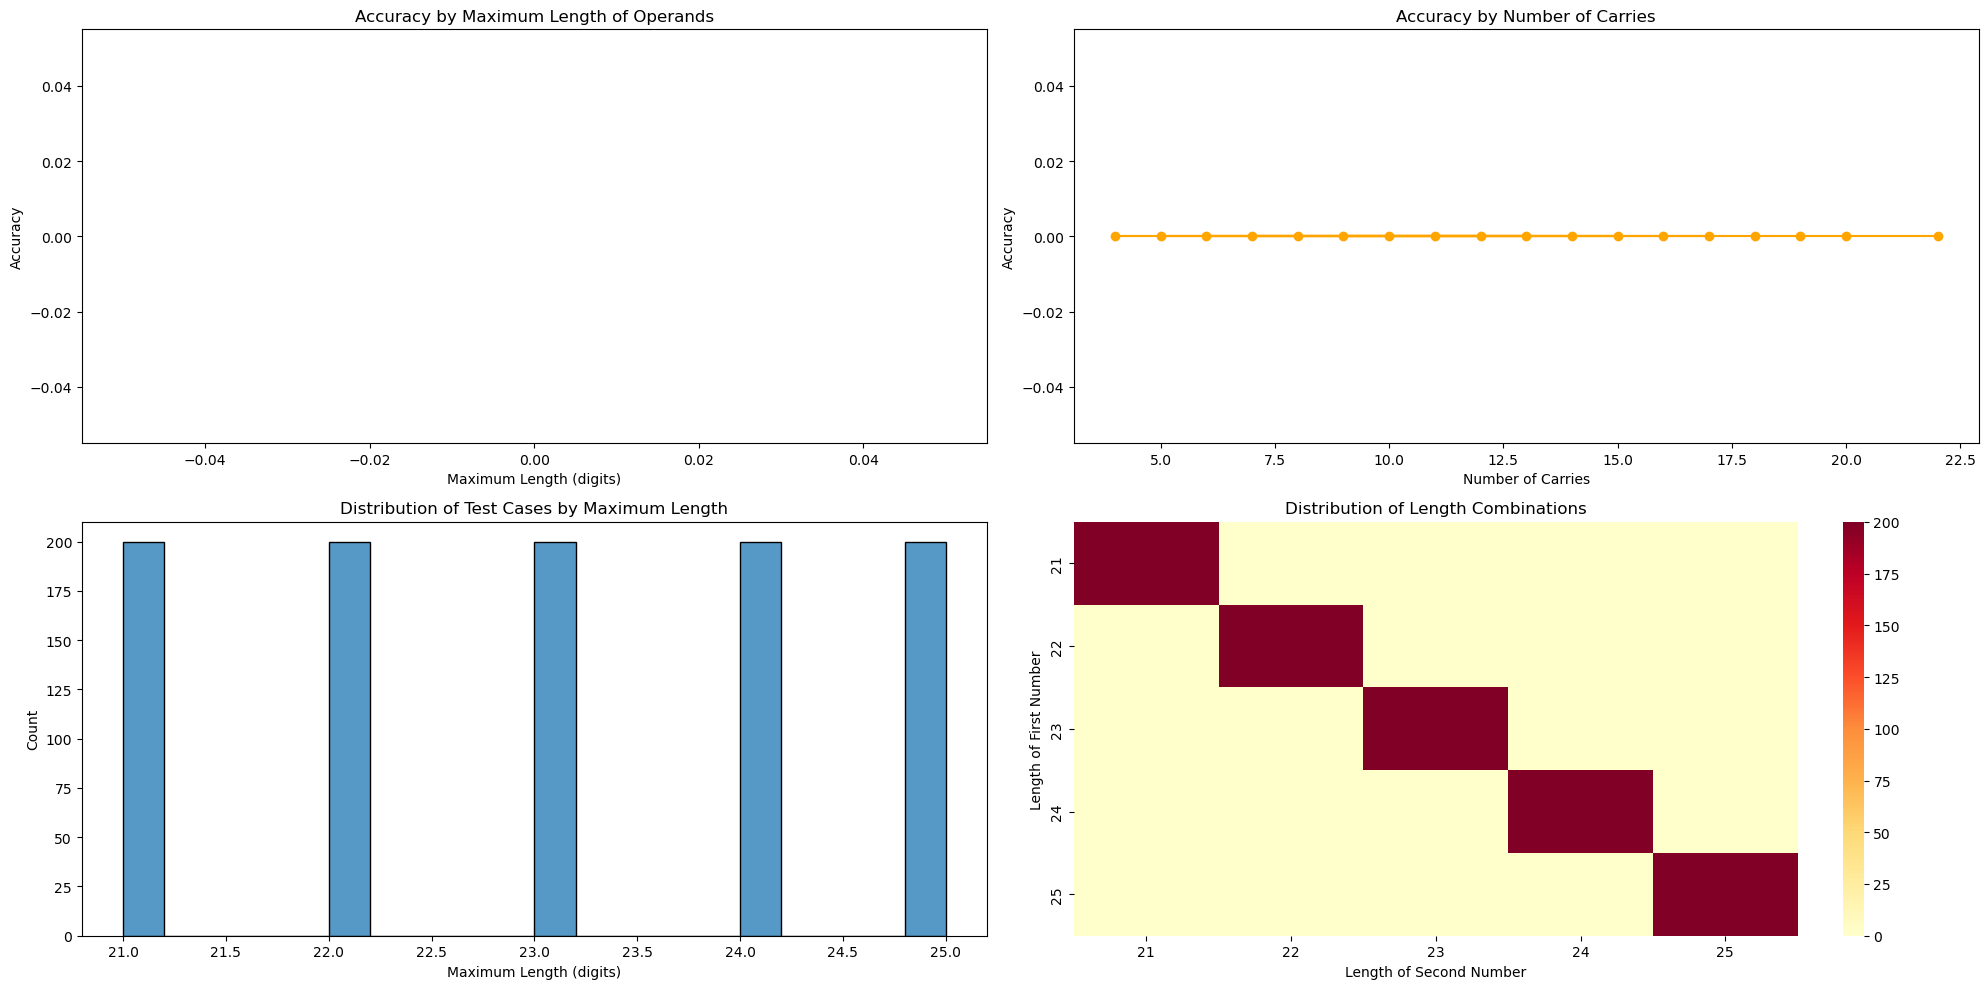


Summary Statistics:
Overall Accuracy: 0.0000
Total Samples: 1000

Detailed Statistics:
Number of correct predictions: 0
Average number of carries: 11.56

Performance by length:
21 digits: 0.0000 (200 samples)
22 digits: 0.0000 (200 samples)
23 digits: 0.0000 (200 samples)
24 digits: 0.0000 (200 samples)
25 digits: 0.0000 (200 samples)


In [13]:
# Third cell: LARGE MODEL EXTENDED RANGE EVALUATION
print("\n# LARGE MODEL EXTENDED RANGE EVALUATION")
# Load model and components
model_path = './Weights/large_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator
evaluator = ExtendedRangeEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=200)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'extended_large_model_evaluation_{timestamp}.csv')

# Print statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

print("\nPerformance by length:")
for length in range(21, 26):
    mask = (results_df['max_len'] == length)
    acc = results_df[mask]['is_correct'].mean()
    samples = sum(mask)
    print(f"{length} digits: {acc:.4f} ({samples} samples)")

In [20]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from datetime import datetime

class ComprehensiveEvaluator(ModelEvaluator):
    def evaluate_model(self, samples_per_length=100):
        """
        Evaluate model with multiple metrics per Schaeffer et al.
        - Traditional accuracy (discontinuous)
        - Token edit distance (linear)
        - Per-token probability (continuous)
        - Brier score for digit prediction (continuous)
        """
        results = []
        digit_lengths = range(1, 21)  # Testing on 1-20 digit numbers
        
        for target_length in digit_lengths:
            for _ in tqdm(range(samples_per_length), 
                         desc=f"Evaluating {target_length} digits"):
                # Generate numbers with exact target length
                num1 = random.randint(10**(target_length-1), 10**target_length - 1)
                num2 = random.randint(10**(target_length-1), 10**target_length - 1)
                true_result = num1 + num2
                
                # Get model prediction
                input_str = f"{num1}+{num2}="
                input_tensor = self.preprocess_input(input_str)
                
                with torch.no_grad():
                    output = self.model(input_tensor)
                    logits = F.softmax(output, dim=-1)
                    pred_str = self.decode_output(output)
                
                try:
                    pred_result = int(pred_str)
                    is_correct = pred_result == true_result
                except ValueError:
                    pred_result = None
                    is_correct = False
                
                # Calculate additional metrics
                target_tokens = str(true_result)
                pred_tokens = str(pred_result) if pred_result is not None else ""
                edit_distance = self.calculate_token_edit_distance(target_tokens, pred_tokens)
                target_token_probs = self.calculate_target_token_probs(logits, str(true_result))
                brier_score = self.calculate_brier_score(logits, str(true_result))
                
                results.append({
                    'num1': num1,
                    'num2': num2,
                    'len1': len(str(num1)),
                    'len2': len(str(num2)),
                    'max_len': max(len(str(num1)), len(str(num2))),
                    'true_result': true_result,
                    'predicted_result': pred_result,
                    'is_correct': is_correct,
                    'carries': self.count_carries(num1, num2),
                    'edit_distance': edit_distance,
                    'mean_token_prob': np.mean(target_token_probs),
                    'brier_score': brier_score
                })
        
        return pd.DataFrame(results)
    
    def calculate_token_edit_distance(self, target, pred):
        """Calculate minimum number of token operations to transform pred into target"""
        m, n = len(target), len(pred)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(m + 1):
            dp[i][0] = i
        for j in range(n + 1):
            dp[0][j] = j
            
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if target[i-1] == pred[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1
        
        return dp[m][n]
    
    def calculate_target_token_probs(self, logits, target):
        """Calculate probability model assigned to each correct target token"""
        probs = []
        for i, digit in enumerate(target):
            if i < logits.size(1):  # Ensure we don't exceed sequence length
                digit_idx = self.vocab[digit]
                prob = logits[0, i, digit_idx].item()
                probs.append(prob)
        return probs
    
    def calculate_brier_score(self, logits, target):
        """Calculate Brier score for digit prediction"""
        brier_scores = []
        for i, digit in enumerate(target):
            if i < logits.size(1):
                target_dist = torch.zeros_like(logits[0, i])
                target_dist[self.vocab[digit]] = 1.0
                brier_scores.append(torch.mean((logits[0, i] - target_dist)**2).item())
        return np.mean(brier_scores)

def analyze_and_visualize_results(results_df, model_name):
    """Generate visualizations and save reports for a model's evaluation results"""
    # Save raw results
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    results_df.to_csv(f'{model_name}_raw_results_{timestamp}.csv')
    
    # Calculate aggregated statistics
    agg_stats = {}
    
    # Overall metrics
    agg_stats['overall'] = {
        'accuracy': results_df['is_correct'].mean(),
        'edit_distance': results_df['edit_distance'].mean(),
        'token_probability': results_df['mean_token_prob'].mean(),
        'brier_score': results_df['brier_score'].mean()
    }
    
    # Metrics by length range
    length_ranges = [(1,5), (6,10), (11,15), (16,20)]
    for start, end in length_ranges:
        mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
        range_name = f'length_{start}_to_{end}'
        agg_stats[range_name] = {
            'accuracy': results_df[mask]['is_correct'].mean(),
            'edit_distance': results_df[mask]['edit_distance'].mean(),
            'token_probability': results_df[mask]['mean_token_prob'].mean(),
            'brier_score': results_df[mask]['brier_score'].mean()
        }
    
    # Save aggregated statistics
    pd.DataFrame(agg_stats).to_csv(f'{model_name}_aggregated_stats_{timestamp}.csv')
    
    # Visualization
    plt.figure(figsize=(20, 10))

    # Plot 1: Traditional Accuracy (Discontinuous)
    plt.subplot(2, 2, 1)
    accuracy_by_length = results_df.groupby('max_len')['is_correct'].mean()
    plt.plot(accuracy_by_length.index, accuracy_by_length.values, marker='o')
    plt.title(f'{model_name}: Traditional Accuracy by Length\n(Discontinuous Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Accuracy')

    # Plot 2: Token Edit Distance (Linear)
    plt.subplot(2, 2, 2)
    edit_distance_by_length = -results_df.groupby('max_len')['edit_distance'].mean()
    plt.plot(edit_distance_by_length.index, edit_distance_by_length.values, marker='o')
    plt.title(f'{model_name}: Token Edit Distance by Length\n(Linear Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Negative Edit Distance')

    # Plot 3: Mean Token Probability (Continuous)
    plt.subplot(2, 2, 3)
    prob_by_length = results_df.groupby('max_len')['mean_token_prob'].mean()
    plt.plot(prob_by_length.index, prob_by_length.values, marker='o')
    plt.title(f'{model_name}: Mean Token Probability by Length\n(Continuous Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Mean Probability')

    # Plot 4: Brier Score (Continuous)
    plt.subplot(2, 2, 4)
    brier_by_length = -results_df.groupby('max_len')['brier_score'].mean()
    plt.plot(brier_by_length.index, brier_by_length.values, marker='o')
    plt.title(f'{model_name}: Brier Score by Length\n(Continuous Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Negative Brier Score')

    plt.tight_layout()
    plt.savefig(f'{model_name}_analysis_plots_{timestamp}.png')
    plt.show()
    
    # Print summary statistics
    print(f"\nDetailed Statistics for {model_name}:")
    print(f"Number of samples: {len(results_df)}")
    print("\nPerformance by metric type:")
    print("\nDiscontinuous Metrics:")
    print(f"Overall Accuracy: {agg_stats['overall']['accuracy']:.4f}")
    
    print("\nLinear Metrics:")
    print(f"Mean Edit Distance: {agg_stats['overall']['edit_distance']:.4f}")
    
    print("\nContinuous Metrics:")
    print(f"Mean Token Probability: {agg_stats['overall']['token_probability']:.4f}")
    print(f"Mean Brier Score: {agg_stats['overall']['brier_score']:.4f}")
    
    print("\nPerformance by length ranges:")
    for start, end in length_ranges:
        range_name = f'length_{start}_to_{end}'
        print(f"\n{start}-{end} digits:")
        print(f"  Accuracy: {agg_stats[range_name]['accuracy']:.4f}")
        print(f"  Edit Distance: {agg_stats[range_name]['edit_distance']:.4f}")
        print(f"  Token Probability: {agg_stats[range_name]['token_probability']:.4f}")
        print(f"  Brier Score: {agg_stats[range_name]['brier_score']:.4f}")


# SMALL MODEL COMPREHENSIVE ANALYSIS
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 64, 'num_heads': 2, 'ff_dim': 256, 'num_layers': 2, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.7937


Evaluating 20 digits: 100%|██████████| 100/100 [00:00<00:00, 104.53it/s]


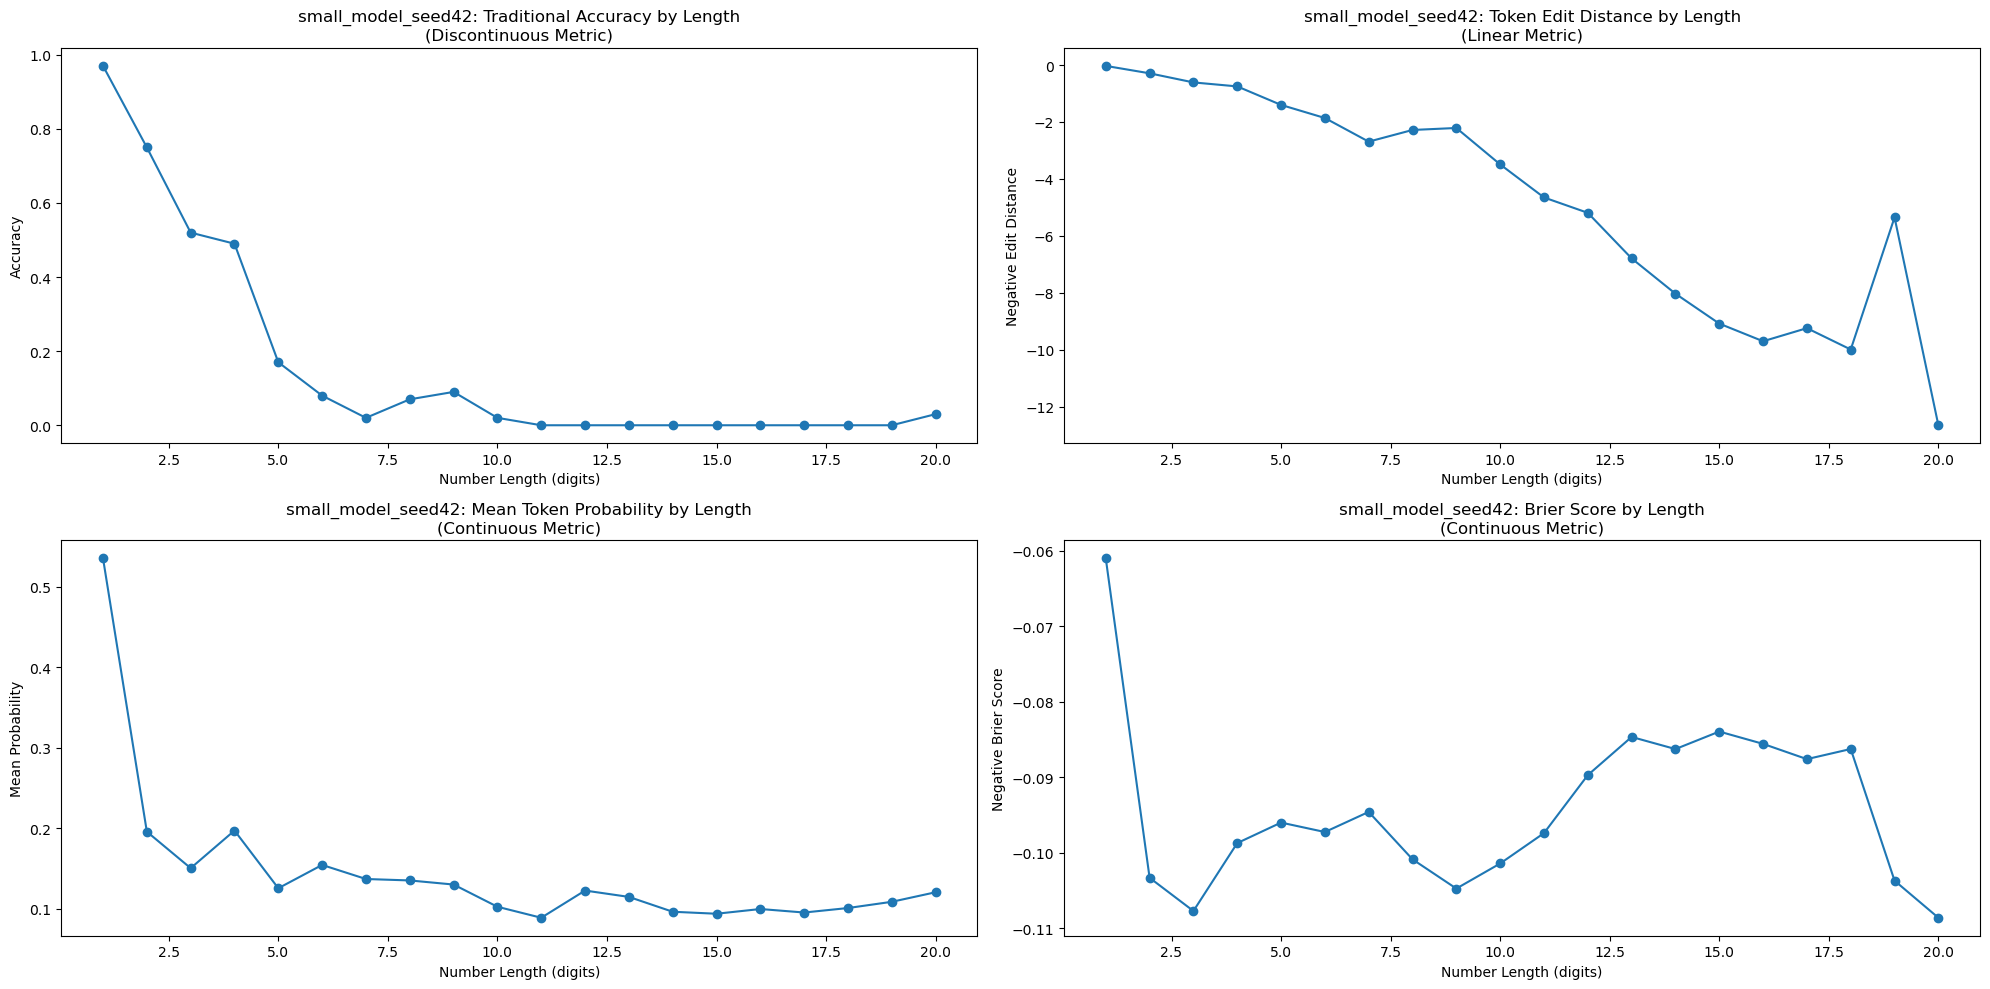


Detailed Statistics for small_model_seed42:
Number of samples: 2000

Performance by metric type:

Discontinuous Metrics:
Overall Accuracy: 0.1605

Linear Metrics:
Mean Edit Distance: 4.8140

Continuous Metrics:
Mean Token Probability: 0.1451
Mean Brier Score: 0.0940

Performance by length ranges:

1-5 digits:
  Accuracy: 0.5800
  Edit Distance: 0.6160
  Token Probability: 0.2406
  Brier Score: 0.0934

6-10 digits:
  Accuracy: 0.0560
  Edit Distance: 2.5060
  Token Probability: 0.1317
  Brier Score: 0.0998

11-15 digits:
  Accuracy: 0.0000
  Edit Distance: 6.7480
  Token Probability: 0.1031
  Brier Score: 0.0884

16-20 digits:
  Accuracy: 0.0060
  Edit Distance: 9.3860
  Token Probability: 0.1049
  Brier Score: 0.0943


In [22]:
# SMALL MODEL COMPREHENSIVE ANALYSIS
print("\n# SMALL MODEL COMPREHENSIVE ANALYSIS")

# Load model and components
model_path = './Weights/small_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed for test generation
evaluator = ComprehensiveEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=100)

# Generate visualizations and save reports
analyze_and_visualize_results(results_df, "small_model_seed42")



# MEDIUM MODEL COMPREHENSIVE ANALYSIS
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 256, 'num_heads': 4, 'ff_dim': 1024, 'num_layers': 4, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.9987


Evaluating 20 digits: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


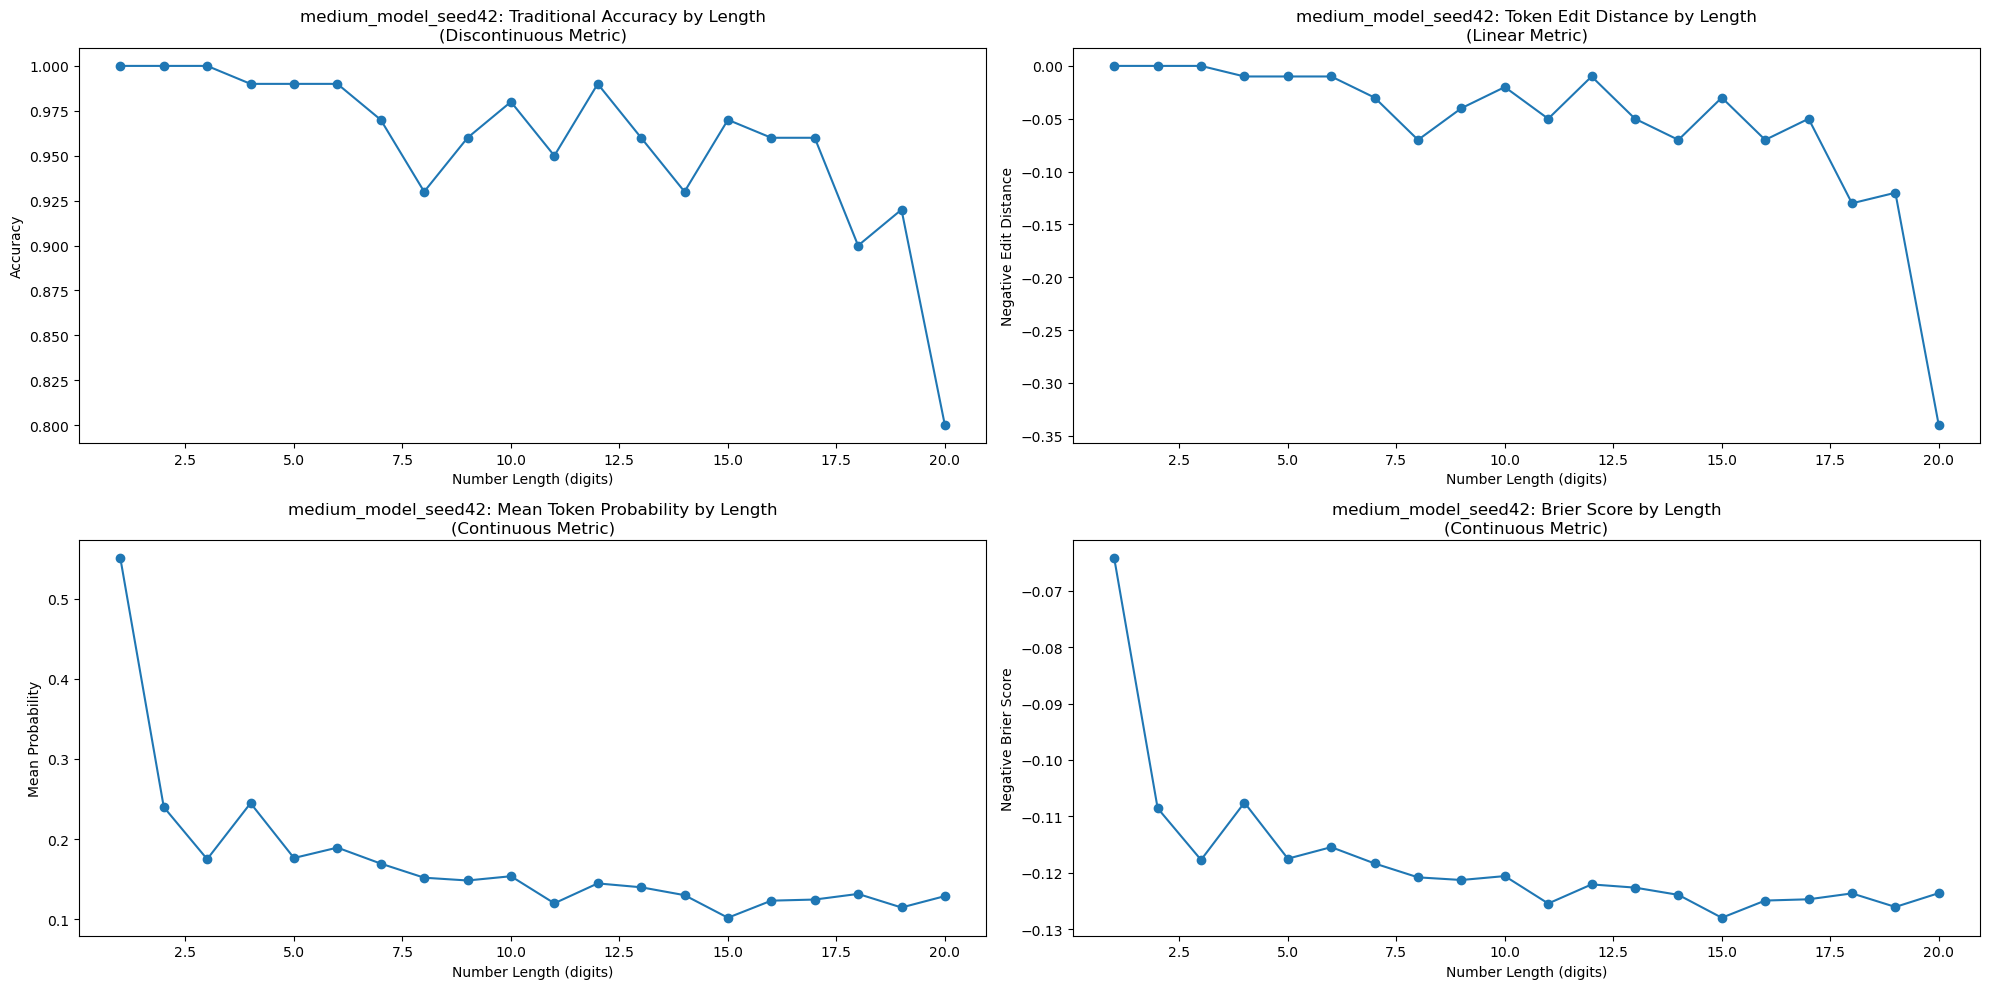


Detailed Statistics for medium_model_seed42:
Number of samples: 2000

Performance by metric type:

Discontinuous Metrics:
Overall Accuracy: 0.9575

Linear Metrics:
Mean Edit Distance: 0.0555

Continuous Metrics:
Mean Token Probability: 0.1730
Mean Brier Score: 0.1179

Performance by length ranges:

1-5 digits:
  Accuracy: 0.9960
  Edit Distance: 0.0040
  Token Probability: 0.2773
  Brier Score: 0.1031

6-10 digits:
  Accuracy: 0.9660
  Edit Distance: 0.0340
  Token Probability: 0.1626
  Brier Score: 0.1193

11-15 digits:
  Accuracy: 0.9600
  Edit Distance: 0.0420
  Token Probability: 0.1274
  Brier Score: 0.1244

16-20 digits:
  Accuracy: 0.9080
  Edit Distance: 0.1420
  Token Probability: 0.1247
  Brier Score: 0.1246


In [23]:
# MEDIUM MODEL COMPREHENSIVE ANALYSIS
print("\n# MEDIUM MODEL COMPREHENSIVE ANALYSIS")

# Load model and components
model_path = './Weights/medium_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with different random seed
evaluator = ComprehensiveEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=100)

# Generate visualizations and save reports
analyze_and_visualize_results(results_df, "medium_model_seed42")


# LARGE MODEL COMPREHENSIVE ANALYSIS
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


Evaluating 20 digits: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


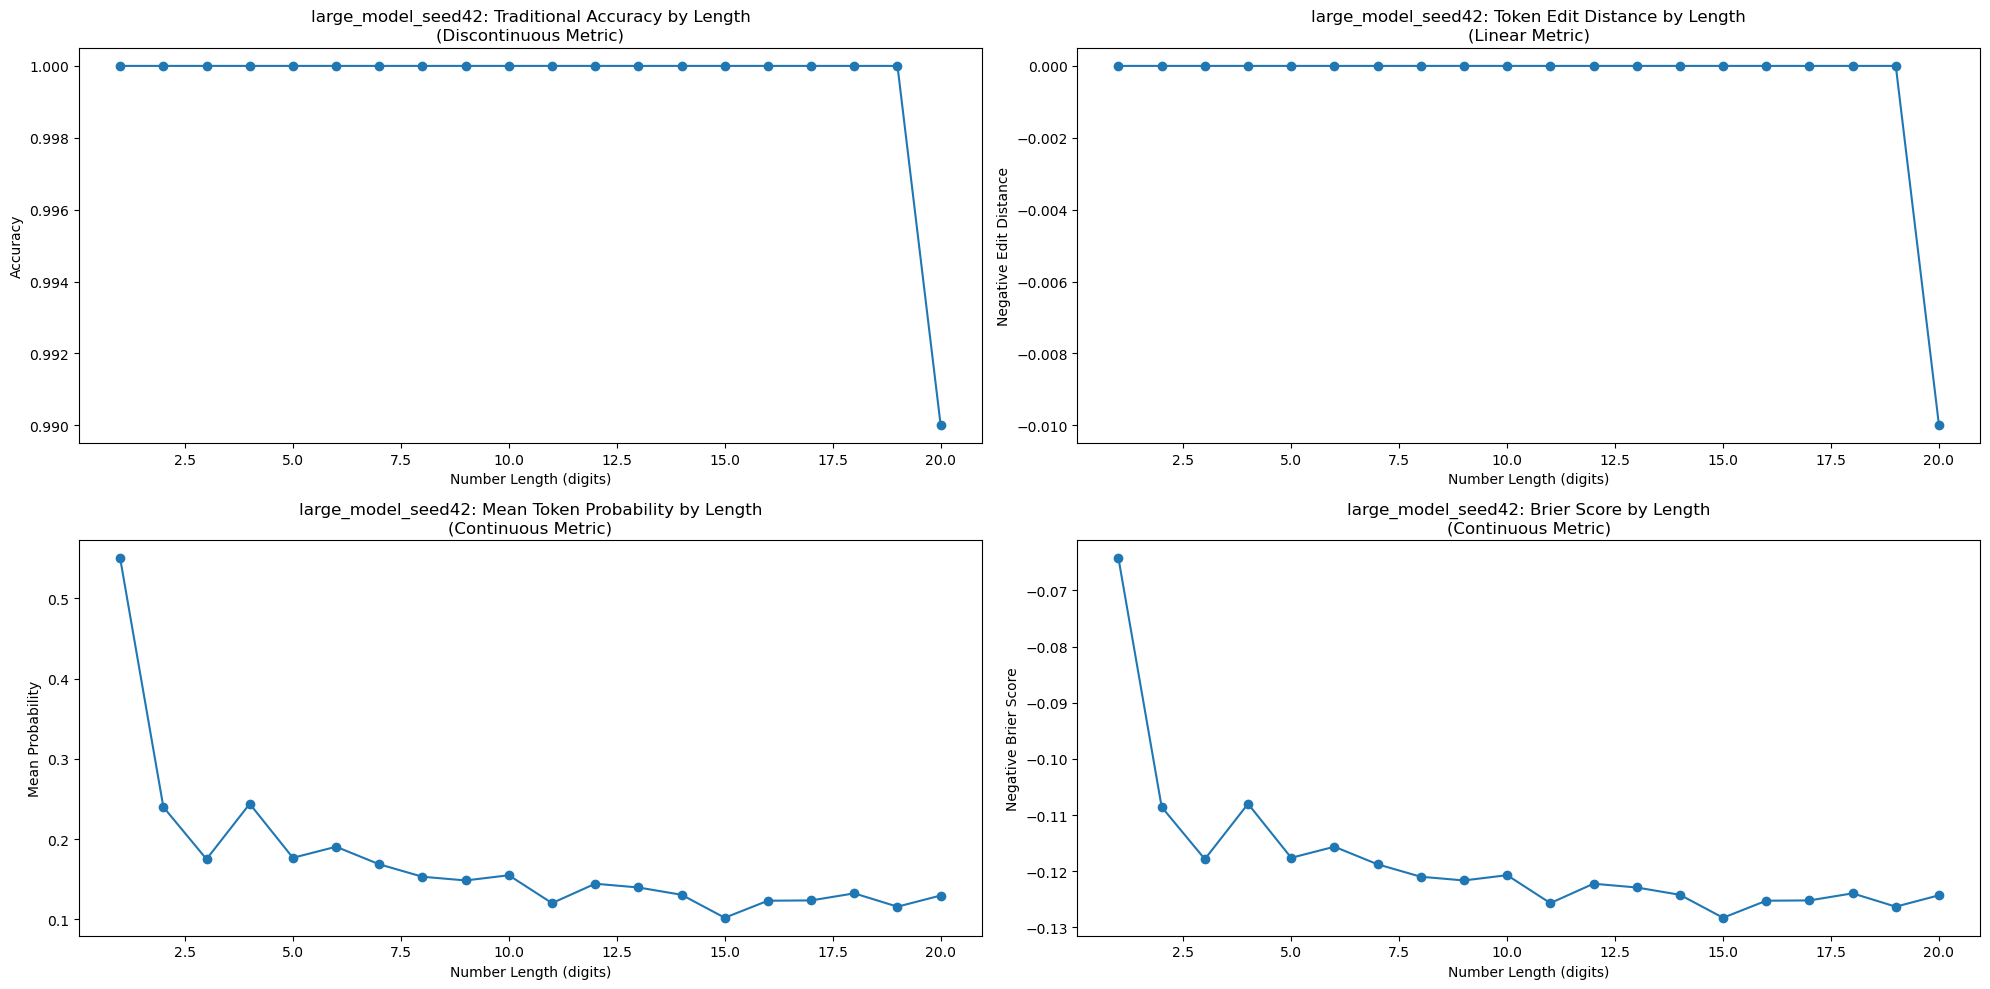


Detailed Statistics for large_model_seed42:
Number of samples: 2000

Performance by metric type:

Discontinuous Metrics:
Overall Accuracy: 0.9995

Linear Metrics:
Mean Edit Distance: 0.0005

Continuous Metrics:
Mean Token Probability: 0.1731
Mean Brier Score: 0.1181

Performance by length ranges:

1-5 digits:
  Accuracy: 1.0000
  Edit Distance: 0.0000
  Token Probability: 0.2771
  Brier Score: 0.1033

6-10 digits:
  Accuracy: 1.0000
  Edit Distance: 0.0000
  Token Probability: 0.1631
  Brier Score: 0.1196

11-15 digits:
  Accuracy: 1.0000
  Edit Distance: 0.0000
  Token Probability: 0.1273
  Brier Score: 0.1247

16-20 digits:
  Accuracy: 0.9980
  Edit Distance: 0.0020
  Token Probability: 0.1249
  Brier Score: 0.1250


In [24]:
# LARGE MODEL COMPREHENSIVE ANALYSIS
print("\n# LARGE MODEL COMPREHENSIVE ANALYSIS")

# Load model and components
model_path = './Weights/large_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with another different random seed
evaluator = ComprehensiveEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=100)

# Generate visualizations and save reports
analyze_and_visualize_results(results_df, "large_model_seed42")

In [25]:
# Import cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Cell to load and prepare data
def extract_param_count(model_name):
    """Extract parameter count from model name and convert to numeric"""
    param_str = model_name.split('_')[1]
    if 'k' in param_str:
        return float(param_str.replace('k', '')) * 1000
    elif 'M' in param_str:
        return float(param_str.replace('M', '')) * 1_000_000
    return float(param_str)

# Load all results
results_dir = Path('Emergence_Testing/Results')
model_results = {}

# Load individual model results
for csv_file in results_dir.glob('model_*.csv'):
    model_name = csv_file.stem
    df = pd.read_csv(csv_file)
    df['param_count'] = extract_param_count(model_name)
    model_results[model_name] = df

# Load aggregate results if it exists
aggregate_path = results_dir / 'aggregate_results.csv'
if aggregate_path.exists():
    aggregate_df = pd.read_csv(aggregate_path)
    # Sort by parameter count
    aggregate_df['parameters'] = pd.to_numeric(aggregate_df['parameters'])
    aggregate_df = aggregate_df.sort_values('parameters')



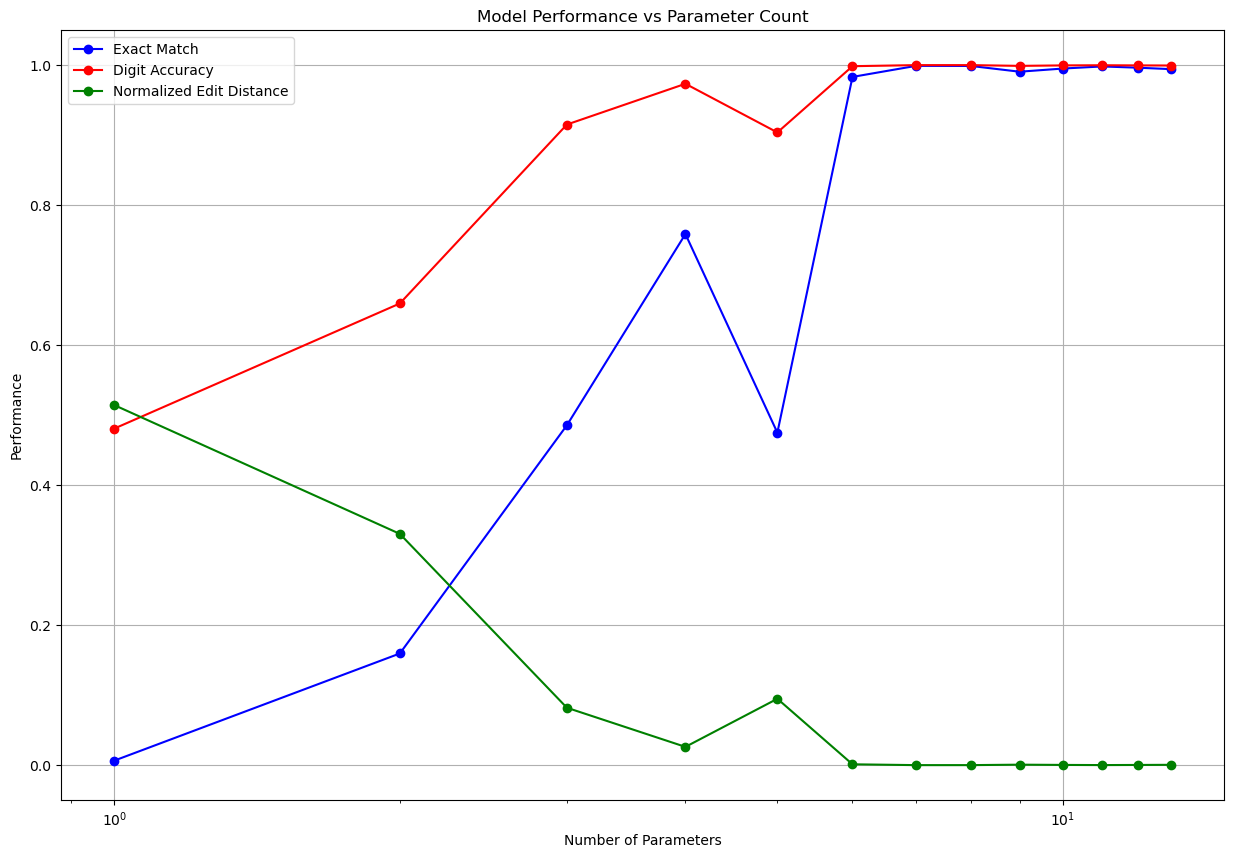

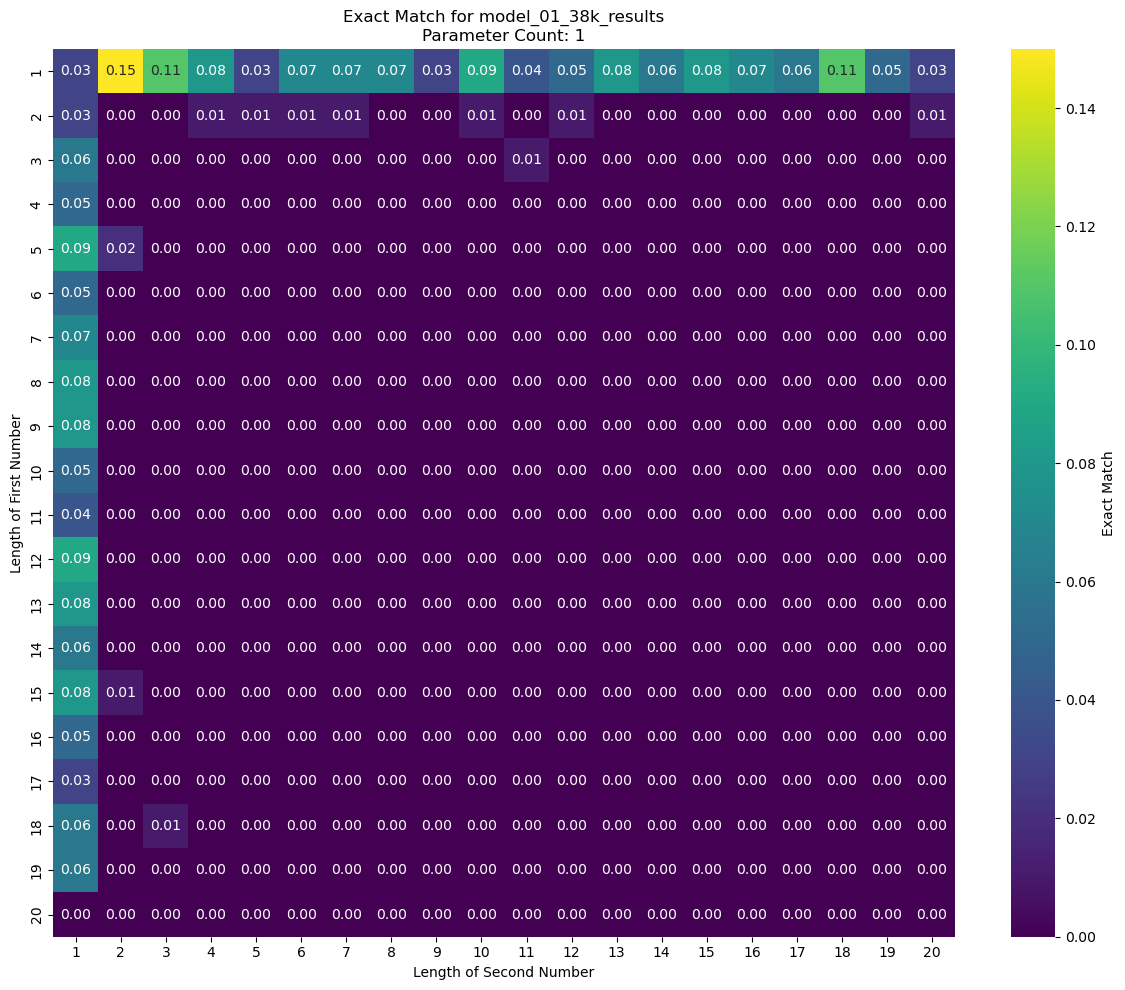

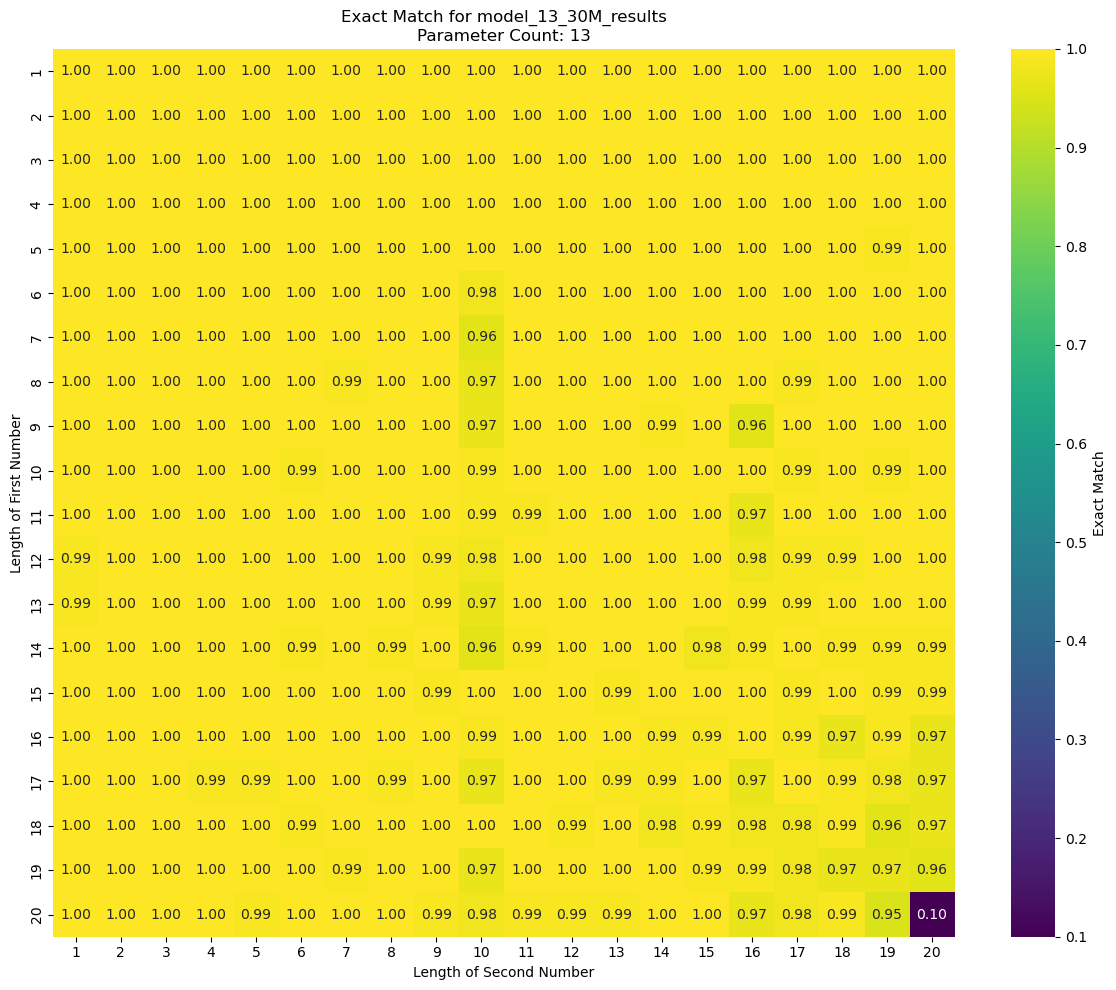

In [27]:
# Cell for emergence curve plots
plt.figure(figsize=(15, 10))

# Plot different metrics from aggregate results
metrics = ['avg_exact_match', 'avg_digit_accuracy', 'avg_normalized_edit_distance']
colors = ['blue', 'red', 'green']

for metric, color in zip(metrics, colors):
    plt.semilogx(aggregate_df['parameters'], 
                 aggregate_df[metric], 
                 marker='o', 
                 linestyle='-', 
                 color=color,
                 label=metric.replace('avg_', '').replace('_', ' ').title())

plt.grid(True)
plt.xlabel('Number of Parameters')
plt.ylabel('Performance')
plt.title('Model Performance vs Parameter Count')
plt.legend()
plt.show()

# Cell for heatmap visualization
def create_length_heatmap(model_name, metric='exact_match'):
    """Create heatmap showing performance across different input lengths"""
    df = model_results[model_name]
    pivot_data = df.pivot(index='length1', columns='length2', values=metric)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_data, cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': metric.replace('_', ' ').title()})
    plt.title(f'{metric.replace("_", " ").title()} for {model_name}\nParameter Count: {int(df["param_count"].iloc[0]):,}')
    plt.xlabel('Length of Second Number')
    plt.ylabel('Length of First Number')
    plt.tight_layout()
    plt.show()

# Create heatmaps for largest and smallest models
model_names = sorted(model_results.keys(), 
                    key=lambda x: model_results[x]['param_count'].iloc[0])
smallest_model = model_names[0]
largest_model = model_names[-1]

create_length_heatmap(smallest_model, 'exact_match')
create_length_heatmap(largest_model, 'exact_match')

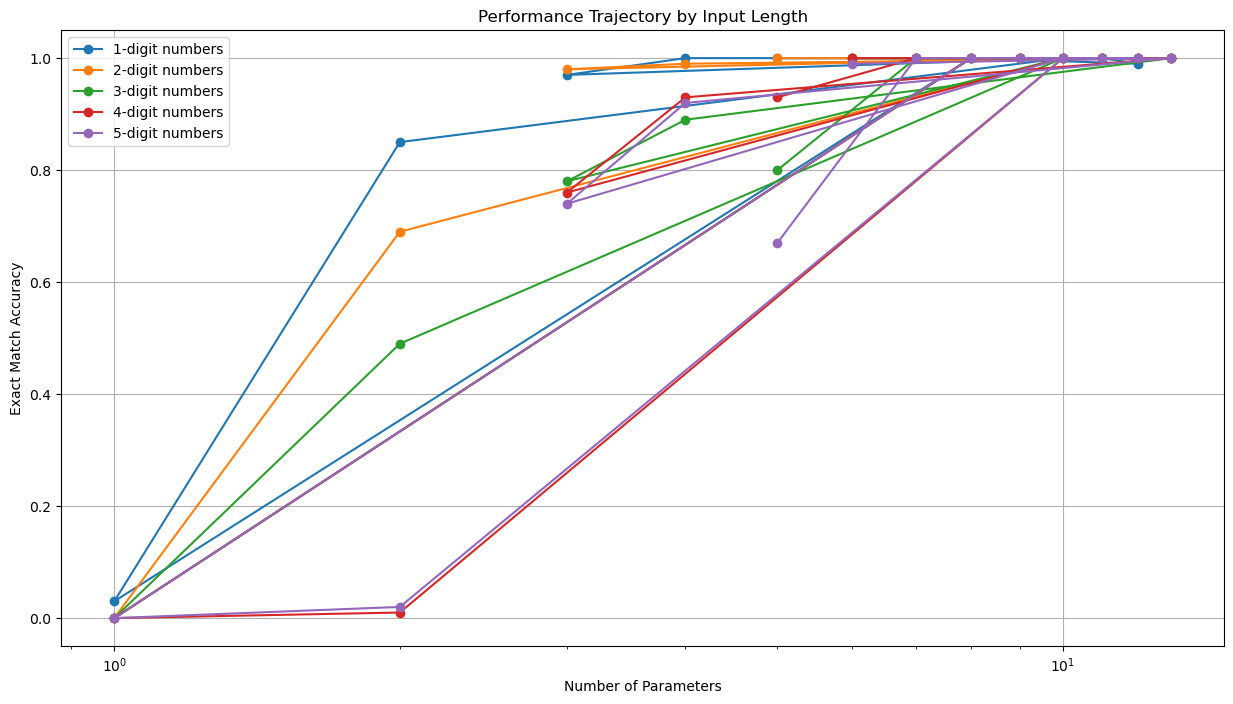

In [28]:
# Cell for performance trajectory analysis
def plot_performance_by_length(max_length=5):
    """Plot how performance changes with parameter count for different input lengths"""
    plt.figure(figsize=(15, 8))
    
    for length in range(1, max_length + 1):
        performances = []
        param_counts = []
        
        for model_name, df in model_results.items():
            # Get results where both numbers have the same length
            length_results = df[(df['length1'] == length) & (df['length2'] == length)]
            if not length_results.empty:
                performances.append(length_results['exact_match'].iloc[0])
                param_counts.append(df['param_count'].iloc[0])
        
        plt.semilogx(param_counts, performances, 
                    marker='o', 
                    linestyle='-', 
                    label=f'{length}-digit numbers')
    
    plt.grid(True)
    plt.xlabel('Number of Parameters')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Performance Trajectory by Input Length')
    plt.legend()
    plt.show()

plot_performance_by_length()

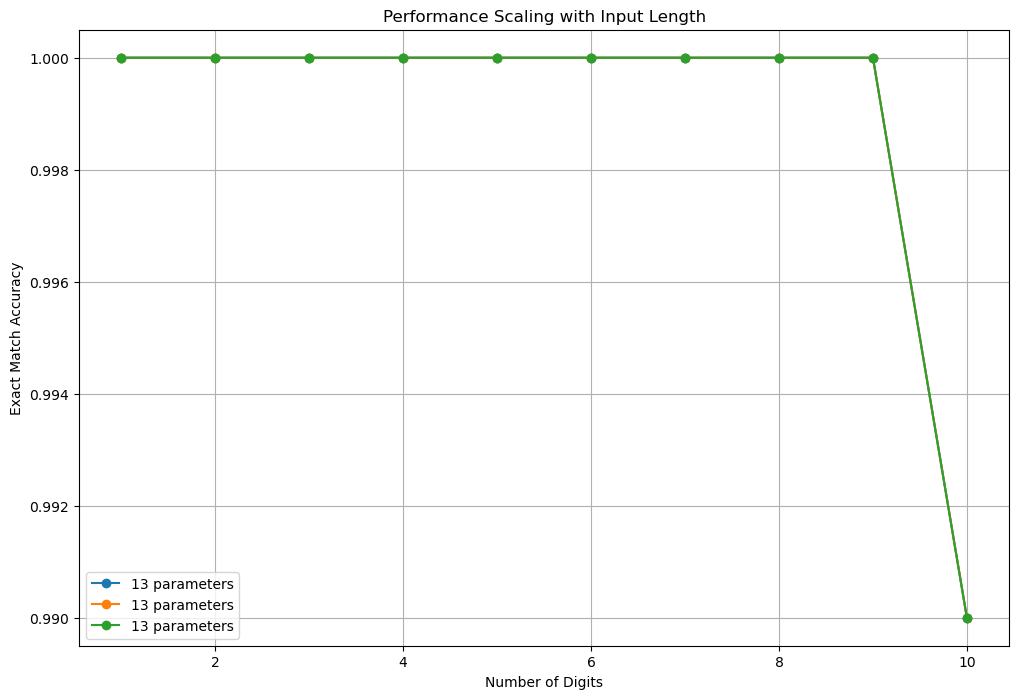

In [29]:
# Cell for performance drop-off analysis
def plot_length_scaling(param_counts=[100000, 1000000, 10000000]):
    """Plot how performance scales with input length for different model sizes"""
    plt.figure(figsize=(12, 8))
    
    for param_count in param_counts:
        # Find model closest to target parameter count
        closest_model = min(model_results.keys(), 
                          key=lambda x: abs(model_results[x]['param_count'].iloc[0] - param_count))
        df = model_results[closest_model]
        
        # Get diagonal performance (where length1 == length2)
        diagonal_perf = []
        lengths = []
        for length in range(1, 11):  # Up to 10-digit numbers
            perf = df[(df['length1'] == length) & (df['length2'] == length)]['exact_match']
            if not perf.empty:
                diagonal_perf.append(perf.iloc[0])
                lengths.append(length)
        
        plt.plot(lengths, diagonal_perf, 
                marker='o', 
                label=f'{int(df["param_count"].iloc[0]):,} parameters')
    
    plt.grid(True)
    plt.xlabel('Number of Digits')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Performance Scaling with Input Length')
    plt.legend()
    plt.show()

plot_length_scaling()

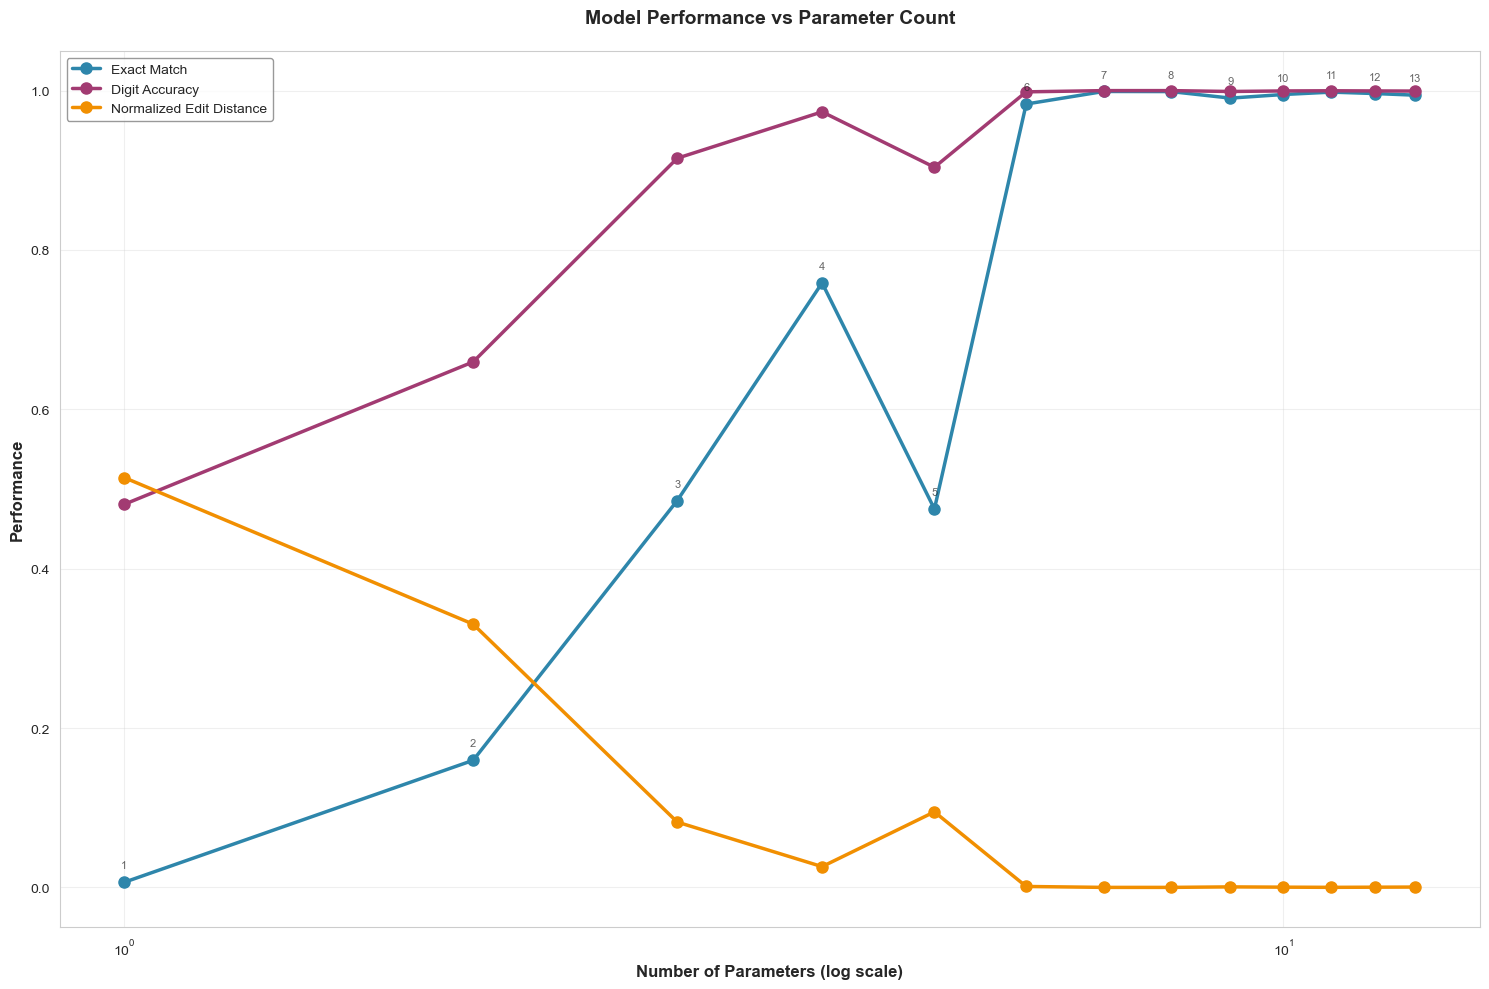

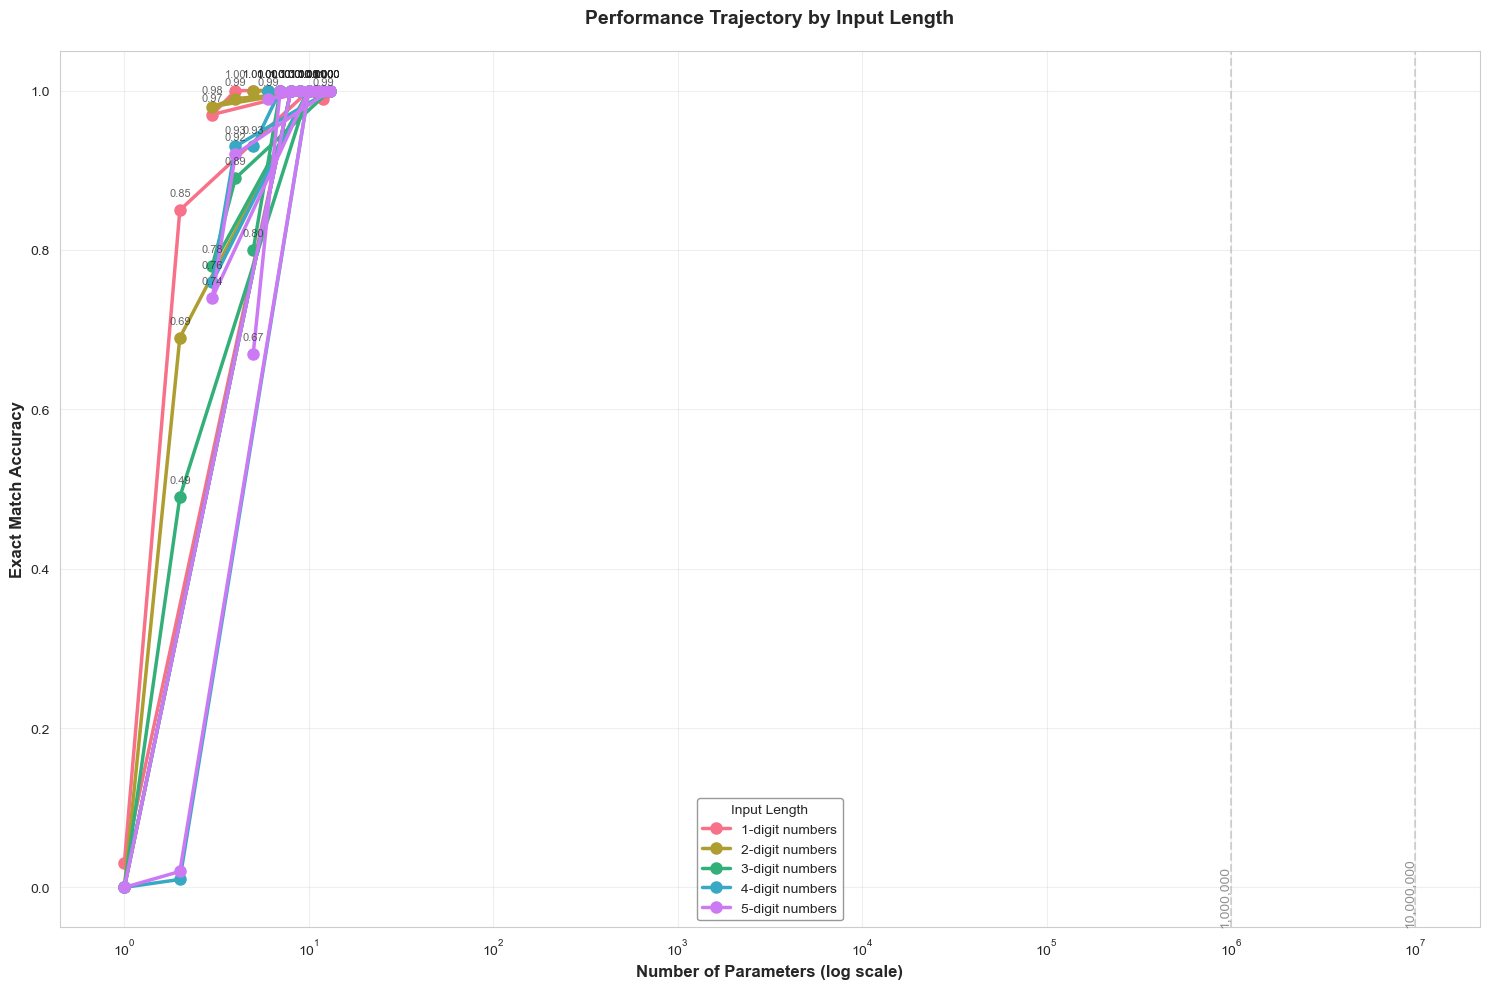

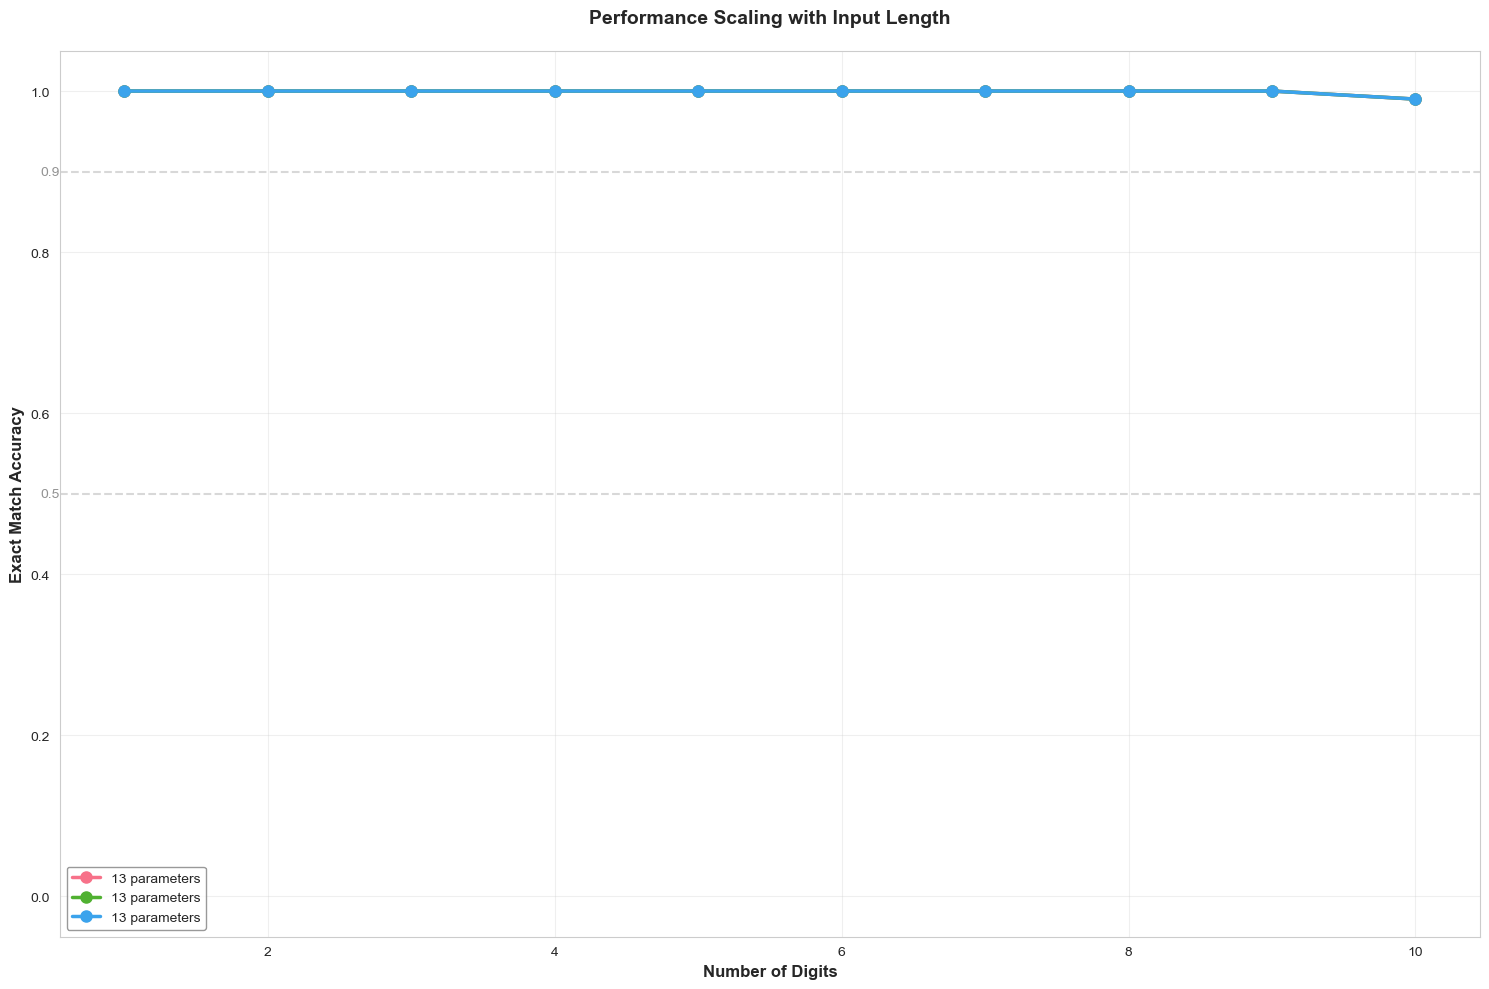

In [30]:
# Performance vs Parameter Count with improved styling
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Plot different metrics with improved styling
metrics = ['avg_exact_match', 'avg_digit_accuracy', 'avg_normalized_edit_distance']
colors = ['#2E86AB', '#A23B72', '#F18F01']  # More distinctive color palette
labels = ['Exact Match', 'Digit Accuracy', 'Normalized Edit Distance']

for metric, color, label in zip(metrics, colors, labels):
    plt.semilogx(aggregate_df['parameters'], 
                 aggregate_df[metric], 
                 marker='o',
                 markersize=8,
                 linestyle='-',
                 linewidth=2.5,
                 color=color,
                 label=label)

plt.grid(True, alpha=0.3)
plt.xlabel('Number of Parameters (log scale)', fontsize=12, fontweight='bold')
plt.ylabel('Performance', fontsize=12, fontweight='bold')
plt.title('Model Performance vs Parameter Count', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray')
plt.tick_params(axis='both', which='major', labelsize=10)

# Add parameter count annotations
for x, y in zip(aggregate_df['parameters'], aggregate_df['avg_exact_match']):
    plt.annotate(f'{int(x):,}', 
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=8,
                alpha=0.7)

plt.tight_layout()
plt.show()

# Improved Performance Trajectory Plot
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

def plot_performance_by_length(max_length=5):
    """Plot how performance changes with parameter count for different input lengths"""
    colors = sns.color_palette("husl", max_length)
    
    for length, color in zip(range(1, max_length + 1), colors):
        performances = []
        param_counts = []
        
        for model_name, df in model_results.items():
            # Get results where both numbers have the same length
            length_results = df[(df['length1'] == length) & (df['length2'] == length)]
            if not length_results.empty:
                performances.append(length_results['exact_match'].iloc[0])
                param_counts.append(df['param_count'].iloc[0])
        
        plt.semilogx(param_counts, performances, 
                    marker='o',
                    markersize=8,
                    linestyle='-',
                    linewidth=2.5,
                    color=color,
                    label=f'{length}-digit numbers')
        
        # Add data point annotations
        for x, y in zip(param_counts, performances):
            if y > 0.1:  # Only annotate significant points
                plt.annotate(f'{y:.2f}',
                           (x, y),
                           textcoords="offset points",
                           xytext=(0,10),
                           ha='center',
                           fontsize=8,
                           alpha=0.7)
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('Number of Parameters (log scale)', fontsize=12, fontweight='bold')
    plt.ylabel('Exact Match Accuracy', fontsize=12, fontweight='bold')
    plt.title('Performance Trajectory by Input Length', fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray', 
              title='Input Length', title_fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    # Add parameter thresholds vertical lines
    thresholds = [1e6, 1e7]  # Example thresholds
    for threshold in thresholds:
        plt.axvline(x=threshold, color='gray', linestyle='--', alpha=0.3)
        plt.text(threshold, plt.ylim()[0], f'{int(threshold):,}', 
                rotation=90, va='bottom', ha='right', alpha=0.5)
    
    plt.ylim(-0.05, 1.05)  # Add some padding to y-axis
    plt.tight_layout()

plot_performance_by_length()
plt.show()

# Improved Length Scaling Plot
def plot_length_scaling(param_counts=[100000, 1000000, 10000000]):
    """Plot how performance scales with input length for different model sizes"""
    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")
    
    colors = sns.color_palette("husl", len(param_counts))
    
    for param_count, color in zip(param_counts, colors):
        closest_model = min(model_results.keys(), 
                          key=lambda x: abs(model_results[x]['param_count'].iloc[0] - param_count))
        df = model_results[closest_model]
        actual_params = df['param_count'].iloc[0]
        
        diagonal_perf = []
        lengths = []
        for length in range(1, 11):
            perf = df[(df['length1'] == length) & (df['length2'] == length)]['exact_match']
            if not perf.empty:
                diagonal_perf.append(perf.iloc[0])
                lengths.append(length)
        
        plt.plot(lengths, diagonal_perf, 
                marker='o',
                markersize=8,
                linewidth=2.5,
                color=color,
                label=f'{int(actual_params):,} parameters')
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('Number of Digits', fontsize=12, fontweight='bold')
    plt.ylabel('Exact Match Accuracy', fontsize=12, fontweight='bold')
    plt.title('Performance Scaling with Input Length', fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray')
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    # Add horizontal threshold lines
    thresholds = [0.5, 0.9]
    for threshold in thresholds:
        plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.3)
        plt.text(plt.xlim()[0], threshold, f'{threshold:.1f}', 
                va='center', ha='right', alpha=0.5)
    
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

plot_length_scaling()

In [107]:
import sys
sys.path.append("Process_Training")
sys.path.append("Scripts")

import torch
from Process_Training.AutoregressiveArithmeticTransformer import create_arithmetic_transformer
import random
from tqdm import tqdm
import pandas as pd
from datetime import datetime

# Add Config class definition to match saved model
class Config:
    def __init__(self):
        # Default values - will be overwritten by checkpoint
        self.vocab_size = 17
        self.embed_size = 64
        self.num_heads = 2
        self.ff_dim = 256
        self.num_layers = 2
        self.max_length = 512
        self.dropout = 0.1
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    @classmethod
    def from_dict(cls, config_dict):
        """Create Config instance from dictionary"""
        config = cls()
        for key, value in config_dict.__dict__.items():
            setattr(config, key, value)
        return config

class ProcessModelTester:
    def __init__(self, model_path):
        """Initialize the tester with model path"""
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model, self.vocab, self.inv_vocab, self.config = self.load_model(model_path)
        print(f"Model loaded successfully on {self.device}")
        
    def load_model(self, model_path):
        """Load the process model and its vocabulary"""
        print(f"Loading model from {model_path}")
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Create config object from checkpoint
        config = Config.from_dict(checkpoint['config'])
        config.device = self.device
        
        # Create and load model
        model = create_arithmetic_transformer(config).to(self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        return model, checkpoint['vocab'], checkpoint['inv_vocab'], config
    
    def generate_sequence(self, num1, num2):
        """Generate input sequence for the model"""
        input_str = f"{num1}+{num2}:"
        tokens = torch.tensor([[self.vocab[c] for c in input_str]], dtype=torch.long)
        return tokens.to(self.device)
    
    def decode_sequence(self, sequence):
        """Decode a sequence of tokens back to string"""
        return ''.join([self.inv_vocab[token.item()] for token in sequence[0]])
    
    def generate_step(self, x, temperature=1.0):
        """Generate one step at a time"""
        with torch.no_grad():
            # Crop context if needed
            if x.size(1) > self.config.max_length:
                x = x[:, -self.config.max_length:]
                
            # Get logits for next token
            logits = self.model(x)
            if len(logits.shape) == 3:
                logits = logits[:, -1, :] / temperature
            
            # Sample from the distribution
            probs = torch.nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            return next_token
    
    def generate_complete(self, x, max_new_tokens):
        """Generate complete sequence"""
        tokens = x
        max_allowed_length = self.config.max_length - 1  # Leave room for one more token
        
        for _ in range(max_new_tokens):
            # Stop if we're at max length
            if tokens.size(1) >= max_allowed_length:
                break
                
            # Get next token
            next_token = self.generate_step(tokens)
            
            # Append to sequence
            tokens = torch.cat([tokens, next_token], dim=1)
            
            # Optional: stop if we see the = token followed by a digit
            last_tokens = tokens[0, -2:].tolist() if tokens.size(1) >= 2 else []
            if len(last_tokens) == 2:
                if last_tokens[0] == self.vocab['=']:  # If we see equals sign
                    if str(last_tokens[1]) in '0123456789':  # Followed by a digit
                        break
        
        return tokens
        
    def parse_output(self, output_str):
        """Parse the output string to extract steps and result"""
        try:
            # Split into process and result
            if '|' not in output_str:
                raise ValueError("No separator '|' found in output")
                
            process, result = output_str.split('|')
            if ':' not in process:
                raise ValueError("No ':' found in process part")
                
            process = process.split(':')[1]  # Remove input part
            
            if '=' not in result:
                raise ValueError("No '=' found in result part")
                
            # Get all digits after the equals sign
            result_str = result.split('=')[1].strip('0')
            if not result_str:
                result_str = '0'
            result = int(result_str)
                
            # Parse individual steps
            steps = []
            for step in process.split(';'):
                if '>' in step:
                    try:
                        before, after = step.split('>')
                        before_parts = before.split(',')
                        after_parts = after.split(',')
                        
                        # Handle malformed steps by padding with zeros if necessary
                        while len(before_parts) < 3:
                            before_parts.append('0')
                        while len(after_parts) < 2:
                            after_parts.append('0')
                            
                        d1, d2, carry_in = map(int, before_parts[:3])
                        digit, carry_out = map(int, after_parts[:2])
                        
                        steps.append({
                            'd1': d1,
                            'd2': d2,
                            'carry_in': carry_in,
                            'result_digit': digit,
                            'carry_out': carry_out
                        })
                    except Exception as e:
                        print(f"Warning: Could not parse step '{step}': {str(e)}")
                        continue
            
            # Process steps in reverse order to check arithmetic
            steps = list(reversed(steps))  # Process right to left
            
            # Validate arithmetic
            running_total = 0
            carry = 0
            power = 0
            arithmetic_valid = True
            
            for step in steps:
                # Calculate expected digit and carry
                total = step['d1'] + step['d2'] + step['carry_in']
                expected_digit = total % 10
                expected_carry = total // 10
                
                # Check if step is arithmetically correct
                if expected_digit != step['result_digit'] or expected_carry != step['carry_out']:
                    step['arithmetic_error'] = True
                    arithmetic_valid = False
                
                # Add to running total (only use result_digit)
                #running_total += step['result_digit'] * (10 ** power)
                running_total = running_total * 10 + step['result_digit']

                power += 1
            
            return {
                'steps': steps,
                'result': int(result_str),
                'calculated_result': running_total,
                'success': True,
                'arithmetic_valid': arithmetic_valid,
                'steps_valid': all(step.get('arithmetic_error', False) == False for step in steps),
                'output_format_valid': len(str(running_total)) == len(result_str)
            }
        except Exception as e:
            return {
                'steps': [],
                'result': None,
                'calculated_result': None,
                'success': False,
                'error': str(e)
            }

    def generate_complete(self, x, max_new_tokens):
        tokens = x
        max_allowed_length = self.config.max_length - 1

        # Get input numbers from sequence
        input_str = self.decode_sequence(x)
        try:
            # Parse input string of format "num1+num2:"
            nums_str = input_str.split('+')
            num1 = int(nums_str[0])
            num2 = int(nums_str[1].rstrip(':'))
            
            # Calculate maximum possible result length
            #max_result_length = max(len(str(num1)), len(str(num2))) + 1
            
            # Calculate the sum of the two numbers
            sum_result = num1 + num2
            max_result_length = len(str(sum_result))
            
            for _ in range(max_new_tokens):
                if tokens.size(1) >= max_allowed_length:
                    break
                
                next_token = self.generate_step(tokens)
                tokens = torch.cat([tokens, next_token], dim=1)
                
                # Check for complete sequence
                output_str = self.decode_sequence(tokens)
                if '|=' in output_str:
                    result_part = output_str.split('|=')[1]
                    if result_part and any(c.isdigit() for c in result_part):
                        digit_count = sum(c.isdigit() for c in result_part)
                        # Stop if we have enough digits for the result
                        if digit_count >= max_result_length:
                            break
        except Exception as e:
            # If parsing fails, fall back to original behavior
            print(f"Warning: Could not parse input numbers ({str(e)}), using default max tokens")
            
        return tokens
        
    def test_addition(self, num1, num2, verbose=True):
        """Test a specific addition problem"""
        try:
            with torch.no_grad():
                x = self.generate_sequence(num1, num2)
                output = self.generate_complete(x, max_new_tokens=self.config.max_length)
                output_str = self.decode_sequence(output)
                parsed = self.parse_output(output_str)
                
                if verbose:
                    print(f"\nTesting: {num1} + {num2}")
                    print(f"Raw output: {output_str}")
                    
                    if parsed['success']:
                        print("\nStep-by-step process (right to left):")
                        for i, step in enumerate(parsed['steps']):
                            print(f"Step {i+1}: {step['d1']} + {step['d2']} + {step['carry_in']} = "
                                f"{step['result_digit']} (carry {step['carry_out']})")
                            if 'arithmetic_error' in step:
                                expected_total = (step['d1'] + step['d2'] + step['carry_in'])
                                print(f"  ERROR: {step['d1']} + {step['d2']} + {step['carry_in']} "
                                    f"should be {expected_total % 10} (carry {expected_total // 10})")
                        
                        print(f"\nModel's result string: {parsed['result']}")
                        print(f"Model's calculated result: {parsed['calculated_result']}")
                        print(f"Actual result: {num1 + num2}")
                        print(f"Step arithmetic valid: {parsed.get('arithmetic_valid', False)}")
                        print(f"Final result correct: {parsed['result'] == num1 + num2}")
                    else:
                        print(f"Error parsing output: {parsed.get('error', 'Unknown error')}")
                
                return {
                    'num1': num1,
                    'num2': num2,
                    'expected': num1 + num2,
                    'output': output_str,
                    'parsed_result': parsed['result'],
                    'calculated_result': parsed.get('calculated_result'),
                    'arithmetic_valid': parsed.get('arithmetic_valid', False),
                    'correct': parsed['success'] and parsed['result'] == num1 + num2,
                    'steps': len(parsed['steps']) if parsed['success'] else 0
                }
        except Exception as e:
            print(f"Error during testing: {str(e)}")
            return {
                'num1': num1,
                'num2': num2,
                'expected': num1 + num2,
                'output': '',
                'parsed_result': None,
                'calculated_result': None,
                'arithmetic_valid': False,
                'correct': False,
                'steps': 0,
                'error': str(e)
            }

    def run_test_suite(self, num_samples=100, max_digits=20):
        """Run a comprehensive test suite"""
        results = []
        
        for _ in tqdm(range(num_samples), desc="Running tests"):
            # Generate random numbers with varying lengths
            len1 = random.randint(1, max_digits)
            len2 = random.randint(1, max_digits)
            
            num1 = random.randint(10**(len1-1), 10**len1-1) if len1 > 1 else random.randint(0, 9)
            num2 = random.randint(10**(len2-1), 10**len2-1) if len2 > 1 else random.randint(0, 9)
            
            # Run test
            result = self.test_addition(num1, num2, verbose=False)
            results.append(result)
        
        # Create DataFrame and compute statistics
        df = pd.DataFrame(results)
        stats = {
            'total_tests': len(df),
            'correct': df['correct'].sum(),
            'accuracy': df['correct'].mean(),
            'avg_steps': df['steps'].mean()
        }
        
        print("\nTest Suite Results:")
        print(f"Total tests: {stats['total_tests']}")
        print(f"Correct: {stats['correct']}")
        print(f"Accuracy: {stats['accuracy']:.4f}")
        print(f"Average steps: {stats['avg_steps']:.2f}")
        
        # Save results
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        df.to_csv(f'process_model_results_{timestamp}.csv', index=False)
        
        return df, stats

def demo_process_model():
    # Load and test model
    #model_path = "Process_Training/trained_models/arithmetic_transformer_final_20241117_224726.pt"

    model_path = "Process_Training/trained_models/arithmetic_transformer_final_20241118_141408.pt"

    tester = ProcessModelTester(model_path)
    
    # Test some specific cases
    test_cases = [
        (123, 456),    # Basic case
        (999, 1),      # Carrying case
        (1000, 9999),  # Different lengths
        (54321, 9876), # Longer numbers
    ]
    
    print("\nTesting specific cases:")
    for num1, num2 in test_cases:
        tester.test_addition(num1, num2)
    
    # Run comprehensive test suite
    #print("\nRunning comprehensive test suite...")
    #results_df, stats = tester.run_test_suite(num_samples=100, max_digits=10)
    
    #return tester, results_df, stats
    return tester, results_df

In [73]:
# Run the demo
#tester, results_df, stats = demo_process_model()
tester, results_df = demo_process_model()

Loading model from Process_Training/trained_models/arithmetic_transformer_final_20241118_141408.pt
Model loaded successfully on cpu

Testing specific cases:

Testing: 123 + 456
Raw output: 123+456:3,6,0>9,0;2,5,0>7,0;1,4,0>5,0|=579

Step-by-step process (right to left):
Step 1: 1 + 4 + 0 = 5 (carry 0)
Step 2: 2 + 5 + 0 = 7 (carry 0)
Step 3: 3 + 6 + 0 = 9 (carry 0)

Model's result string: 579
Model's calculated result: 579
Actual result: 579
Step arithmetic valid: True
Final result correct: True

Testing: 999 + 1
Raw output: 999+1:9,1,1>0,1;9,0,1>0,1;9,0,1>0,1;0,0,1>1,0|=1000

Step-by-step process (right to left):
Step 1: 0 + 0 + 1 = 1 (carry 0)
Step 2: 9 + 0 + 1 = 0 (carry 1)
Step 3: 9 + 0 + 1 = 0 (carry 1)
Step 4: 9 + 1 + 1 = 0 (carry 1)
  ERROR: 9 + 1 + 1 should be 1 (carry 1)

Model's result string: 1
Model's calculated result: 1000
Actual result: 1000
Step arithmetic valid: False
Final result correct: False

Testing: 1000 + 9999
Raw output: 1000+9999:0,9,0>9,0;0,9,0>9,0;0,9,0>9,0;1

In [78]:
# Or test specific cases
tester.test_addition(15, 9)

# Or run a custom test suite
#results_df, stats = tester.run_test_suite(num_samples=50, max_digits=5)


Testing: 15 + 9
Raw output: 15+9:5,9,1>4,1;1,0,0>2,0|=24

Step-by-step process (right to left):
Step 1: 1 + 0 + 0 = 2 (carry 0)
  ERROR: 1 + 0 + 0 should be 1 (carry 0)
Step 2: 5 + 9 + 1 = 4 (carry 1)
  ERROR: 5 + 9 + 1 should be 5 (carry 1)

Model's result string: 24
Model's calculated result: 24
Actual result: 24
Step arithmetic valid: False
Final result correct: True


{'num1': 15,
 'num2': 9,
 'expected': 24,
 'output': '15+9:5,9,1>4,1;1,0,0>2,0|=24',
 'parsed_result': 24,
 'calculated_result': 24,
 'arithmetic_valid': False,
 'correct': True,
 'steps': 2}

In [119]:
def demo_process_limited_model():
    # Load and test model
    #model_path = "Process_Training/trained_models/arithmetic_transformer_final_20241117_224726.pt"
    
    # 3 Digit model
    #model_path = "Process_Training/trained_models/arithmetic_transformer_final_20241118_160908.pt"
    model_path = "Process_Training/large_3_model/arithmetic_transformer_final_20241118_172730.pt"

    
    # 4 Digit model
    #model_path = "Process_Training/trained_models/arithmetic_transformer_final_20241118_165124.pt"
    #model_path = "Process_Training/large_4_model/arithmetic_transformer_final_20241118_184427.pt"


    tester = ProcessModelTester(model_path)
    
    # Test some specific cases
    test_cases = [
        (123, 456),    # Basic case
        #(999, 1),      # Carrying case
        #(1000, 9999),  # Different lengths
        #(54321, 9876), # Longer numbers
    ]
    
    print("\nTesting specific cases:")
    for num1, num2 in test_cases:
        tester.test_addition(num1, num2)
    
    # Run comprehensive test suite
    #print("\nRunning comprehensive test suite...")
    #results_df, stats = tester.run_test_suite(num_samples=100, max_digits=10)
    
    #return tester, results_df, stats
    return tester, results_df

In [120]:
tester_limited, results_limited_df = demo_process_limited_model()

Loading model from Process_Training/large_3_model/arithmetic_transformer_final_20241118_172730.pt
Model loaded successfully on cpu

Testing specific cases:

Testing: 123 + 456
Raw output: 123+456:3,6,0>9,0;2,5,0>7,0;1,4,0>5,0|=579

Step-by-step process (right to left):
Step 1: 1 + 4 + 0 = 5 (carry 0)
Step 2: 2 + 5 + 0 = 7 (carry 0)
Step 3: 3 + 6 + 0 = 9 (carry 0)

Model's result string: 579
Model's calculated result: 579
Actual result: 579
Step arithmetic valid: True
Final result correct: True


In [130]:
tester_limited.test_addition(44, 1)


Testing: 44 + 1
Raw output: 44+1:4,1,0>5,0;4,0,0>4,0|=45

Step-by-step process (right to left):
Step 1: 4 + 0 + 0 = 4 (carry 0)
Step 2: 4 + 1 + 0 = 5 (carry 0)

Model's result string: 45
Model's calculated result: 45
Actual result: 45
Step arithmetic valid: True
Final result correct: True


{'num1': 44,
 'num2': 1,
 'expected': 45,
 'output': '44+1:4,1,0>5,0;4,0,0>4,0|=45',
 'parsed_result': 45,
 'calculated_result': 45,
 'arithmetic_valid': True,
 'correct': True,
 'steps': 2}

In [137]:
import sys
sys.path.append("/Users/pranavdhinakar/Documents/LLM/Experiments")

import torch
from Process_Training.AutoregressiveArithmeticTransformer import create_arithmetic_transformer
from Process_Training.PaperBasedTrainer import Config

def load_model(model_path):
    """Load the trained model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create config from checkpoint
    config = checkpoint['config']
    config.device = device
    
    # Create model and load state
    model = create_arithmetic_transformer(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['vocab'], checkpoint['inv_vocab'], config

def test_addition(model, vocab, inv_vocab, num1, num2, config):
    """Test the model on a single addition problem"""
    device = config.device
    
    # Create input sequence
    input_str = f"Input: {num1}+{num2}\nTarget:\n"
    tokens = []
    for c in input_str:
        if c in vocab:
            tokens.append(vocab[c])
    
    x = torch.tensor([tokens], dtype=torch.long).to(device)
    
    # Generate output
    with torch.no_grad():
        for _ in range(50):  # Maximum new tokens to generate
            if x.size(1) > config.max_length:
                x = x[:, -config.max_length:]
            
            logits = model(x)
            next_token = logits[:, -1, :].argmax(dim=-1)
            x = torch.cat([x, next_token.unsqueeze(0)], dim=1)
    
    # Convert output tokens back to string
    output = ''.join([inv_vocab[t.item()] for t in x[0]])
    print(f"\nInput problem: {num1} + {num2}")
    print(f"Model output:\n{output}")
    
    return output

# Load and test model
model_path = "/Users/pranavdhinakar/Documents/LLM/Experiments/Process_Training/latest_training/best_model.pt"
model, vocab, inv_vocab, config = load_model(model_path)

# Test some examples
test_cases = [
    (2, 3),    # Simple single digit
    #(12, 34),  # Two digit
    #(123, 456), # Three digit
    #(45, 67),   # Two digit with carry
    #(999, 1)    # Edge case with many carries
]

for num1, num2 in test_cases:
    test_addition(model, vocab, inv_vocab, num1, num2, config)


Input problem: 2 + 3
Model output:
Input: 2+3
Target:
A->5, C->0.
55t:et: 4et:
T0.
A->5C->5C->5C->5+15t:


In [139]:
import sys
import torch
import torch.nn.functional as F
from Process_Training.AutoregressiveArithmeticTransformer import create_arithmetic_transformer
from Process_Training.PaperBasedTrainer import Config

def load_model(model_path):
    """Load the trained model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    config.device = device
    model = create_arithmetic_transformer(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Print vocabulary for debugging
    print("\nVocabulary mapping:")
    for char, idx in sorted(checkpoint['vocab'].items()):
        print(f"'{char}': {idx}")
        
    return model, checkpoint['vocab'], checkpoint['inv_vocab'], config

def generate_next_token(model, x, vocab, temperature=0.8, top_k=10):
    """Generate next token with temperature sampling and top-k filtering"""
    with torch.no_grad():
        logits = model(x)
        next_token_logits = logits[:, -1, :] / temperature
        
        # Get top-k token probabilities and indices
        top_k_probs, top_k_indices = torch.topk(F.softmax(next_token_logits, dim=-1), k=top_k)
        
        # Sample from top-k
        next_token_idx = torch.multinomial(top_k_probs[0], num_samples=1)
        next_token = top_k_indices[0][next_token_idx]
        
        # For debugging, get the actual character and probability
        token_char = vocab.get(next_token.item(), '?')
        token_prob = top_k_probs[0][next_token_idx].item()
        
        return next_token, token_char, token_prob

def test_addition(model, vocab, inv_vocab, num1, num2, config, max_new_tokens=50):
    """Test the model on a single addition problem with enhanced debugging"""
    device = config.device
    
    # Create input sequence
    input_str = f"Input: {num1}+{num2}\nTarget:\n"
    tokens = []
    for c in input_str:
        if c in vocab:
            tokens.append(vocab[c])
        else:
            print(f"Warning: Character '{c}' not in vocabulary!")
    
    x = torch.tensor([tokens], dtype=torch.long).to(device)
    generated_sequence = x.clone()
    
    print(f"\nInput problem: {num1} + {num2}")
    print("Generation process:")
    print("-" * 50)
    print(f"Initial input: {input_str}")
    print("Token-by-token generation:")
    
    generated_chars = []
    current_line = ""
    
    # Generate output
    with torch.no_grad():
        for i in range(max_new_tokens):
            if generated_sequence.size(1) > config.max_length:
                generated_sequence = generated_sequence[:, -config.max_length:]
            
            # Generate next token with debugging info
            next_token, token_char, token_prob = generate_next_token(model, generated_sequence, inv_vocab)
            generated_sequence = torch.cat([generated_sequence, next_token.unsqueeze(0)], dim=1)
            
            # Print token generation info
            print(f"Step {i+1:2d}: Generated '{token_char}' (prob: {token_prob:.4f})")
            
            generated_chars.append(token_char)
            current_line += token_char
            
            # Check for line endings
            if token_char == '\n':
                if current_line.strip().isdigit():  # If line contains only digits
                    try:
                        result = int(current_line.strip())
                        if result == num1 + num2:  # Correct result found
                            break
                    except ValueError:
                        pass
                current_line = ""
    
    # Convert full sequence back to string
    output = ''.join(generated_chars)
    
    print("\nFinal output:")
    print("-" * 50)
    print(output)
    
    # Try to extract the result
    try:
        lines = output.split('\n')
        # Look for a line that starts with 'A->' for the carry steps
        carry_lines = [line for line in lines if line.startswith('A->')]
        # Look for a line containing only digits for the final result
        result_line = next((line for line in reversed(lines) if line.strip().isdigit()), None)
        
        if result_line:
            predicted_result = int(result_line)
            actual_result = num1 + num2
            print(f"\nPredicted result: {predicted_result}")
            print(f"Actual result: {actual_result}")
            print(f"Correct: {predicted_result == actual_result}")
            
            if carry_lines:
                print("\nCarry steps found:")
                for line in carry_lines:
                    print(line)
            else:
                print("\nNo carry steps found in output")
    except Exception as e:
        print(f"\nError parsing result: {str(e)}")
        print("Lines found in output:")
        for line in output.split('\n'):
            if line.strip():
                print(f"'{line}'")
    
    return output

def run_test_suite():
    """Run a suite of test cases"""
    print("Loading model...")
    model_path = "/Users/pranavdhinakar/Documents/LLM/Experiments/Process_Training/latest_training/best_model.pt"
    model, vocab, inv_vocab, config = load_model(model_path)
    
    test_cases = [
        (2, 3),  # Simple case
        (5, 4),  # Another simple case
        (0, 7),  # Edge case with zero
        (9, 1),  # Edge case near 10
    ]
    
    print("\nStarting test suite...")
    print("=" * 50)
    
    results = []
    for num1, num2 in test_cases:
        output = test_addition(model, vocab, inv_vocab, num1, num2, config)
        results.append((num1, num2, output))
        print("=" * 50)
    
    return results

if __name__ == "__main__":
    results = run_test_suite()

Loading model...

Vocabulary mapping:
'
': 19
' ': 18
'+': 12
',': 17
'-': 16
'.': 31
'0': 0
'1': 1
'2': 2
'3': 3
'4': 4
'5': 5
'6': 6
'7': 7
'8': 8
'9': 9
':': 20
'>': 13
'A': 14
'C': 15
'I': 21
'T': 26
'a': 27
'e': 30
'g': 29
'n': 22
'p': 23
'r': 28
't': 25
'u': 24

Starting test suite...

Input problem: 2 + 3
Generation process:
--------------------------------------------------
Initial input: Input: 2+3
Target:

Token-by-token generation:
Step  1: Generated 'A' (prob: 1.0000)
Step  2: Generated '-' (prob: 1.0000)
Step  3: Generated '>' (prob: 1.0000)
Step  4: Generated '5' (prob: 1.0000)
Step  5: Generated ',' (prob: 1.0000)
Step  6: Generated ' ' (prob: 1.0000)
Step  7: Generated 'C' (prob: 1.0000)
Step  8: Generated '-' (prob: 1.0000)
Step  9: Generated '>' (prob: 1.0000)
Step 10: Generated '0' (prob: 1.0000)
Step 11: Generated '.' (prob: 1.0000)
Step 12: Generated '
' (prob: 1.0000)
Step 13: Generated '5' (prob: 1.0000)
Step 14: Generated '5' (prob: 0.9999)
Step 15: Generated 'C